<a href="https://colab.research.google.com/github/Stanfording/small_GAN_testing/blob/main/try_styleGAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Goal:   Just get a small GAN running



Get the preprocessed celebHD data from google drive

In [1]:
# #Download the dataset
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1KqBRLsB0CJuQGycvaPINwaPgcGDUsAxN' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1KqBRLsB0CJuQGycvaPINwaPgcGDUsAxN" -O "proCeleba.zip" && rm -rf /tmp/cookies.txt

# #unzip the dataset
# !unzip "/content/proCeleba.zip"

# #remove unnecessary files
# !rm -rf /content/__MACOSX

Streaming output truncated to the last 5000 lines.
  inflating: proCeleba/512/052408.jpg  
  inflating: proCeleba/512/045174.jpg  
  inflating: proCeleba/512/018267.jpg  
  inflating: proCeleba/512/155415.jpg  
  inflating: proCeleba/512/077878.jpg  
  inflating: proCeleba/512/068958.jpg  
  inflating: proCeleba/512/008074.jpg  
  inflating: proCeleba/512/145606.jpg  
  inflating: proCeleba/512/191331.jpg  
  inflating: proCeleba/512/007347.jpg  
  inflating: proCeleba/512/041312.jpg  
  inflating: proCeleba/512/115031.jpg  
  inflating: proCeleba/512/006059.jpg  
  inflating: proCeleba/512/186895.jpg  
  inflating: proCeleba/512/200484.jpg  
  inflating: proCeleba/512/198473.jpg  
  inflating: proCeleba/512/001050.jpg  
  inflating: proCeleba/512/197026.jpg  
  inflating: proCeleba/512/021380.jpg  
  inflating: proCeleba/512/056108.jpg  
  inflating: proCeleba/512/163819.jpg  
  inflating: proCeleba/512/018501.jpg  
  inflating: proCeleba/512/085350.jpg  
  inflating: proCeleba/512/15

## Import libraries

In [2]:
#!python3 -m pip install -f https://release.oneflow.info oneflow==0.7.0+cu102

In [3]:
#import oneflow as t

In [4]:
from tqdm import tqdm

from torch.autograd import Variable, grad
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import os
import torch as t
import torch.nn as nn
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
from skimage import io
import copy

### Set initial hyperparameters

In [5]:

batch_size = 64

resolution = 16

img_fold_dir_64_reso = f"/content/proCeleba/{resolution}"

iteration = 300

critic = 30    

eval_size = 25

laten_space = 100

updatD_step = 5

device = t.device('cuda' if t.cuda.is_available() else 'cpu')

log_folder = "log"
!mkdir "log"
!mkdir "log/checkpoint"
!mkdir "log/sample"

### Show me which gpu I am using.

In [6]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-574ee4a9-bda6-1c17-b60c-373ffaeefbe0)


### Pre loading the data

In [7]:
# Define a data class for load unclassfied data.
class Get_No_Classes_Img_Dataset(Dataset):
    
    def __init__(self, folder_dir, transform = None):
        self.folder_dir = os.path.join(folder_dir)
        self.transform = transform
        self.image_list = os.listdir(self.folder_dir)
        
    def __len__(self):
        return len(os.listdir(self.folder_dir))
    
    def __getitem__(self, index):
        
        image_name = self.image_list[index]
        
        image_dir = os.path.join(self.folder_dir, image_name)
        
        image = io.imread(image_dir)
        
        if (self.transform != None):
            image = self.transform(image)
        
        return image
    

transform = transforms.Compose([
    transforms.ToTensor(),        #From Batch * Highth * Width * Channel to Batch * Channel * Highth * Width
                                  #Which is what pytorch CNN can work with.
                                
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
]) 
dataset = Get_No_Classes_Img_Dataset(img_fold_dir_64_reso, transform = transform) 
                                                            # datasets[0].shape = (16,16,3)
                                                            # len(datasets) = 28000
total_data_len = len(dataset)
                                                                                            
#datasets_batched = DataLoader(datasets, batch_size = batch_size) #loader is renewed every epoch




```
loader = iter(loader)
print(next(loader).shape) 
```
will output


```
torch.Size([batch_size, 3, resolution, resolution])
```

So data loading is ready.

What's left is keep using 

```
next(loader)
```
to access each batch of data


### Visualize a picture

In [8]:
from IPython.display import Image, display




# Viewing one data sample function:
def showOneImge(img, i, shouldSave):
    
    img = img.squeeze()
    
    img = transforms.ToPILImage()(img)
    
    plt.figure(figsize = (10,10), dpi = 10)
    plt.axis('off')
    
    if shouldSave:
      saveDir = f'{log_folder}/sample/{str(i).zfill(6)}.png'
      plt.imshow(img)
      plt.savefig(saveDir, bbox_inches='tight', pad_inches = 0)
      img = Image(saveDir)
      display(img)
    else:
      deleteDir = f"{log_folder}/sample/Delete.png"
      plt.imshow(img)
      plt.savefig(deleteDir, bbox_inches='tight', pad_inches = 0)
      img = Image(deleteDir)
      display(img)
      !rm "/content/log/sample/Delete.png"
    return 

''' Testing showOneImage'''
# loader = DataLoader(datasets, batch_size = batch_size)

# data = iter(loader)

# oneSample = next(data)[0]

# showOneImge(oneSample, 9999, True)


def showMoreImages(img, num):

  subplot_x = int(num ** (1/2))
  subplot_y = num // subplot_x
  plt.figure(figsize = (2,2))
  for i in range(len(img)):
      aimg = transforms.ToPILImage()(img[i])
      plt.subplot(subplot_x, subplot_y, i+1)
      plt.imshow(aimg)
      plt.axis('off')


-------------------------------------------------

### Now Designing the simple GAN network

In [9]:
"""
Define the generator
"""

class G(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.laten = nn.Sequential(
            nn.Linear(laten_space, 100),
            nn.Linear(100, 500),
            nn.Linear(500, 128 * resolution * resolution))

        self.model = nn.Sequential(
            nn.Conv2d(128, 64, (3, 3), padding = "same"),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 32, (3, 3), padding = "same"),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 3, (3, 3), padding = "same"),
            nn.Sigmoid()
        )
        
        
        
    def forward(self, theInput, batch_size):
        
        x = self.laten(theInput)
        
        x = t.reshape(x, (batch_size, 128, resolution, resolution))
         
        x = self.model(x)
            
            
        return x
    
class D(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.netWork = nn.Sequential(
            nn.Conv2d(3, 64, (3, 3), padding = "same"),
            nn.LeakyReLU(),
            nn.Dropout2d(0.3),
            nn.Conv2d(64, 128, (3, 3), stride = (3, 3)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 1, (3, 3), stride = (3, 3)),
            nn.Flatten())
        
    def forward(self, theInput):
        
        return self.netWork(theInput)

### Testing the network

In [10]:
"""

Testing the net work:

"""

# oneImg = next(iter(datasets))[0]

# showOneImge(oneImg, 0)

# oneImg = oneImg.expand(1,3,64,64)

# print(oneImg.shape)

# print(oneImg)

# #img into G to test shape

# input_noise_example = t.randn((batch_size, 1, 1, 5))

# a = G()(input_noise_example, batch_size)
# print(a[0])
# showOneImge(a[0], 0)

# b = D()(next(loader))

# print(b.shape)

'\n\nTesting the net work:\n\n'

### Gradient Penalty from wGAN.

In [11]:
def compute_gradient_penalty(D, real_samples, fake_samples, current_batch_size):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = t.randn((current_batch_size, 1, 1, 1)).to(device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    
    
    d_interpolates = D(interpolates)
    
    
    grad_x_hat = grad(
            outputs=d_interpolates.sum(), inputs=interpolates, create_graph=True)[0]
    grad_penalty = ((grad_x_hat.view(grad_x_hat.size(0), -1)
                      .norm(2, dim=1) - 1)**2).mean()
    grad_penalty = 10 * grad_penalty
    
    return grad_penalty

### Initializing the generator, discriminator, optimizer, labels, and loss.

In [13]:
generator = G().to(device)
discriminator = D().to(device)
discriminatorReal = D().to(device)

G_optimizer = t.optim.Adam(generator.parameters(), lr = 0.00001)
D_optimizer = t.optim.Adam(discriminator.parameters(), lr = 0.00001)

label_real = t.ones((batch_size, 1)).to(device)
label_fake = t.zeros((batch_size, 1)).to(device)


### Start training

Epoch: 1: 100%|██████████| 438/438 [00:38<00:00, 11.29it/s, D_total_loss=-.432, G_loss=0.195, fake_score=-.171, real_score=0.49]


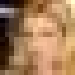

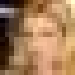

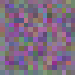

epoch =  1
Epoch [0/500], Step [438/438], d_loss: -0.4324, g_loss: 0.1949, D(x): 0.49, D(G(z)): -0.17


Epoch: 3: 100%|██████████| 438/438 [00:21<00:00, 20.54it/s, D_total_loss=-1.41, G_loss=0.56, fake_score=-.504, real_score=1.02]


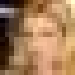

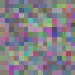

epoch =  3
Epoch [2/500], Step [438/438], d_loss: -1.4121, g_loss: 0.5599, D(x): 1.02, D(G(z)): -0.50


Epoch: 5: 100%|██████████| 438/438 [00:21<00:00, 20.24it/s, D_total_loss=-1.89, G_loss=0.865, fake_score=-.901, real_score=1.24]


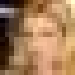

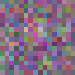

epoch =  5
Epoch [4/500], Step [438/438], d_loss: -1.8879, g_loss: 0.8651, D(x): 1.24, D(G(z)): -0.90


Epoch: 7: 100%|██████████| 438/438 [00:21<00:00, 20.46it/s, D_total_loss=-1.85, G_loss=1.21, fake_score=-1.15, real_score=1.17]


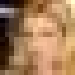

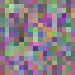

epoch =  7
Epoch [6/500], Step [438/438], d_loss: -1.8528, g_loss: 1.2115, D(x): 1.17, D(G(z)): -1.15


Epoch: 9: 100%|██████████| 438/438 [00:21<00:00, 20.51it/s, D_total_loss=-2.46, G_loss=1.67, fake_score=-1.6, real_score=0.975]


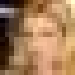

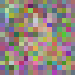

epoch =  9
Epoch [8/500], Step [438/438], d_loss: -2.4620, g_loss: 1.6658, D(x): 0.98, D(G(z)): -1.60


Epoch: 11: 100%|██████████| 438/438 [00:21<00:00, 20.70it/s, D_total_loss=-2.51, G_loss=1.94, fake_score=-2.08, real_score=0.604]


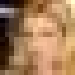

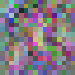

epoch =  11
Epoch [10/500], Step [438/438], d_loss: -2.5108, g_loss: 1.9365, D(x): 0.60, D(G(z)): -2.08


Epoch: 13: 100%|██████████| 438/438 [00:21<00:00, 20.72it/s, D_total_loss=-2.61, G_loss=2.57, fake_score=-2.44, real_score=0.233]


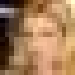

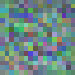

epoch =  13
Epoch [12/500], Step [438/438], d_loss: -2.6067, g_loss: 2.5711, D(x): 0.23, D(G(z)): -2.44


Epoch: 15: 100%|██████████| 438/438 [00:21<00:00, 20.44it/s, D_total_loss=-2.65, G_loss=2.93, fake_score=-2.98, real_score=-.163]


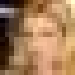

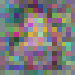

epoch =  15
Epoch [14/500], Step [438/438], d_loss: -2.6472, g_loss: 2.9269, D(x): -0.16, D(G(z)): -2.98


Epoch: 17: 100%|██████████| 438/438 [00:21<00:00, 20.35it/s, D_total_loss=-2.42, G_loss=3.62, fake_score=-3.49, real_score=-.554]


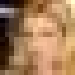

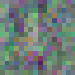

epoch =  17
Epoch [16/500], Step [438/438], d_loss: -2.4226, g_loss: 3.6170, D(x): -0.55, D(G(z)): -3.49


Epoch: 19: 100%|██████████| 438/438 [00:21<00:00, 20.64it/s, D_total_loss=-3.07, G_loss=4.23, fake_score=-4.18, real_score=-.972]


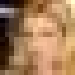

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


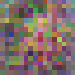

epoch =  19
Epoch [18/500], Step [438/438], d_loss: -3.0708, g_loss: 4.2311, D(x): -0.97, D(G(z)): -4.18


Epoch: 21: 100%|██████████| 438/438 [00:23<00:00, 18.61it/s, D_total_loss=-3.16, G_loss=4.9, fake_score=-4.73, real_score=-1.37]


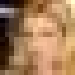

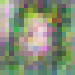

epoch =  21
Epoch [20/500], Step [438/438], d_loss: -3.1633, g_loss: 4.8994, D(x): -1.37, D(G(z)): -4.73


Epoch: 23: 100%|██████████| 438/438 [00:22<00:00, 19.58it/s, D_total_loss=-3.37, G_loss=5.08, fake_score=-5.22, real_score=-1.51]


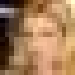

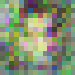

epoch =  23
Epoch [22/500], Step [438/438], d_loss: -3.3728, g_loss: 5.0813, D(x): -1.51, D(G(z)): -5.22


Epoch: 25: 100%|██████████| 438/438 [00:22<00:00, 19.31it/s, D_total_loss=-3.59, G_loss=5.6, fake_score=-5.42, real_score=-1.67]


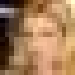

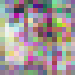

epoch =  25
Epoch [24/500], Step [438/438], d_loss: -3.5926, g_loss: 5.5965, D(x): -1.67, D(G(z)): -5.42


Epoch: 27: 100%|██████████| 438/438 [00:22<00:00, 19.40it/s, D_total_loss=-3.03, G_loss=5.53, fake_score=-5.57, real_score=-1.67]


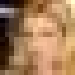

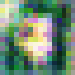

epoch =  27
Epoch [26/500], Step [438/438], d_loss: -3.0304, g_loss: 5.5297, D(x): -1.67, D(G(z)): -5.57


Epoch: 29: 100%|██████████| 438/438 [00:23<00:00, 19.02it/s, D_total_loss=-3.47, G_loss=5.26, fake_score=-5.25, real_score=-1.58]


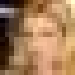

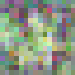

epoch =  29
Epoch [28/500], Step [438/438], d_loss: -3.4669, g_loss: 5.2609, D(x): -1.58, D(G(z)): -5.25


Epoch: 31: 100%|██████████| 438/438 [00:23<00:00, 18.61it/s, D_total_loss=-2.22, G_loss=4.99, fake_score=-4.59, real_score=-1.44]


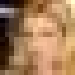

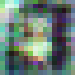

epoch =  31
Epoch [30/500], Step [438/438], d_loss: -2.2248, g_loss: 4.9931, D(x): -1.44, D(G(z)): -4.59


Epoch: 33: 100%|██████████| 438/438 [00:23<00:00, 18.36it/s, D_total_loss=-2.59, G_loss=4.2, fake_score=-4.08, real_score=-1.31]


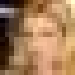

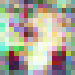

epoch =  33
Epoch [32/500], Step [438/438], d_loss: -2.5918, g_loss: 4.1989, D(x): -1.31, D(G(z)): -4.08


Epoch: 35: 100%|██████████| 438/438 [00:23<00:00, 18.36it/s, D_total_loss=-2.72, G_loss=4.09, fake_score=-3.87, real_score=-.868]


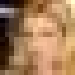

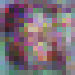

epoch =  35
Epoch [34/500], Step [438/438], d_loss: -2.7236, g_loss: 4.0885, D(x): -0.87, D(G(z)): -3.87


Epoch: 37: 100%|██████████| 438/438 [00:24<00:00, 18.16it/s, D_total_loss=-3.05, G_loss=3.26, fake_score=-3.57, real_score=-.316]


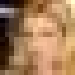

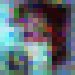

epoch =  37
Epoch [36/500], Step [438/438], d_loss: -3.0452, g_loss: 3.2629, D(x): -0.32, D(G(z)): -3.57


Epoch: 39: 100%|██████████| 438/438 [00:23<00:00, 18.89it/s, D_total_loss=-2.91, G_loss=2.89, fake_score=-2.67, real_score=0.329]


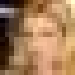

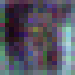

epoch =  39
Epoch [38/500], Step [438/438], d_loss: -2.9052, g_loss: 2.8942, D(x): 0.33, D(G(z)): -2.67


Epoch: 41: 100%|██████████| 438/438 [00:23<00:00, 18.61it/s, D_total_loss=-3.07, G_loss=2.75, fake_score=-2.41, real_score=0.723]


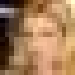

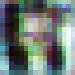

epoch =  41
Epoch [40/500], Step [438/438], d_loss: -3.0711, g_loss: 2.7532, D(x): 0.72, D(G(z)): -2.41


Epoch: 43: 100%|██████████| 438/438 [00:23<00:00, 18.28it/s, D_total_loss=-3.15, G_loss=2.27, fake_score=-2.43, real_score=0.902]


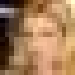

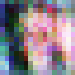

epoch =  43
Epoch [42/500], Step [438/438], d_loss: -3.1465, g_loss: 2.2741, D(x): 0.90, D(G(z)): -2.43


Epoch: 45: 100%|██████████| 438/438 [00:23<00:00, 18.40it/s, D_total_loss=-2.62, G_loss=2.27, fake_score=-1.99, real_score=0.746]


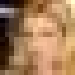

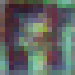

epoch =  45
Epoch [44/500], Step [438/438], d_loss: -2.6161, g_loss: 2.2710, D(x): 0.75, D(G(z)): -1.99


Epoch: 47: 100%|██████████| 438/438 [00:23<00:00, 18.33it/s, D_total_loss=5.49, G_loss=1.93, fake_score=-1.64, real_score=1.1]


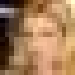

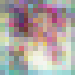

epoch =  47
Epoch [46/500], Step [438/438], d_loss: 5.4886, g_loss: 1.9303, D(x): 1.10, D(G(z)): -1.64


Epoch: 49: 100%|██████████| 438/438 [00:23<00:00, 18.38it/s, D_total_loss=-3.53, G_loss=2.04, fake_score=-2.06, real_score=1.55]


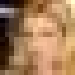

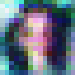

epoch =  49
Epoch [48/500], Step [438/438], d_loss: -3.5284, g_loss: 2.0369, D(x): 1.55, D(G(z)): -2.06


Epoch: 51: 100%|██████████| 438/438 [00:23<00:00, 18.36it/s, D_total_loss=-3.11, G_loss=2.31, fake_score=-1.98, real_score=1.26]


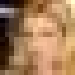

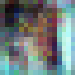

epoch =  51
Epoch [50/500], Step [438/438], d_loss: -3.1112, g_loss: 2.3131, D(x): 1.26, D(G(z)): -1.98


Epoch: 53: 100%|██████████| 438/438 [00:23<00:00, 18.38it/s, D_total_loss=-2.81, G_loss=2.15, fake_score=-2.38, real_score=1.31]


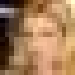

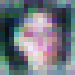

epoch =  53
Epoch [52/500], Step [438/438], d_loss: -2.8107, g_loss: 2.1456, D(x): 1.31, D(G(z)): -2.38


Epoch: 55: 100%|██████████| 438/438 [00:24<00:00, 17.96it/s, D_total_loss=-3.32, G_loss=2.11, fake_score=-1.88, real_score=1.55]


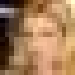

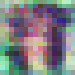

epoch =  55
Epoch [54/500], Step [438/438], d_loss: -3.3214, g_loss: 2.1134, D(x): 1.55, D(G(z)): -1.88


Epoch: 57: 100%|██████████| 438/438 [00:24<00:00, 18.22it/s, D_total_loss=-2.71, G_loss=1.89, fake_score=-1.29, real_score=1.72]


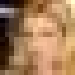

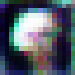

epoch =  57
Epoch [56/500], Step [438/438], d_loss: -2.7093, g_loss: 1.8894, D(x): 1.72, D(G(z)): -1.29


Epoch: 59: 100%|██████████| 438/438 [00:24<00:00, 18.03it/s, D_total_loss=-3.39, G_loss=1.81, fake_score=-1.71, real_score=2.09]


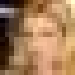

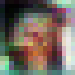

epoch =  59
Epoch [58/500], Step [438/438], d_loss: -3.3889, g_loss: 1.8070, D(x): 2.09, D(G(z)): -1.71


Epoch: 61: 100%|██████████| 438/438 [00:24<00:00, 18.20it/s, D_total_loss=-2.03, G_loss=1.74, fake_score=-1.34, real_score=2.73]


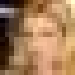

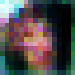

epoch =  61
Epoch [60/500], Step [438/438], d_loss: -2.0335, g_loss: 1.7434, D(x): 2.73, D(G(z)): -1.34


Epoch: 63: 100%|██████████| 438/438 [00:24<00:00, 18.04it/s, D_total_loss=-4.16, G_loss=1.51, fake_score=-1.88, real_score=2.42]


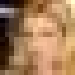

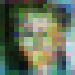

epoch =  63
Epoch [62/500], Step [438/438], d_loss: -4.1605, g_loss: 1.5065, D(x): 2.42, D(G(z)): -1.88


Epoch: 65: 100%|██████████| 438/438 [00:24<00:00, 18.20it/s, D_total_loss=-3.09, G_loss=1.45, fake_score=-1.56, real_score=2.13]


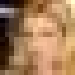

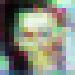

epoch =  65
Epoch [64/500], Step [438/438], d_loss: -3.0874, g_loss: 1.4477, D(x): 2.13, D(G(z)): -1.56


Epoch: 67: 100%|██████████| 438/438 [00:24<00:00, 18.06it/s, D_total_loss=-2.1, G_loss=1.62, fake_score=-1.39, real_score=2.63]


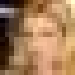

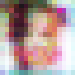

epoch =  67
Epoch [66/500], Step [438/438], d_loss: -2.1010, g_loss: 1.6238, D(x): 2.63, D(G(z)): -1.39


Epoch: 69: 100%|██████████| 438/438 [00:24<00:00, 17.87it/s, D_total_loss=-2.99, G_loss=1.23, fake_score=-1.62, real_score=2.25]


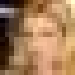

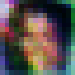

epoch =  69
Epoch [68/500], Step [438/438], d_loss: -2.9860, g_loss: 1.2279, D(x): 2.25, D(G(z)): -1.62


Epoch: 71: 100%|██████████| 438/438 [00:24<00:00, 18.20it/s, D_total_loss=-4.31, G_loss=1.26, fake_score=-1.57, real_score=3.01]


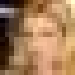

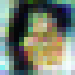

epoch =  71
Epoch [70/500], Step [438/438], d_loss: -4.3072, g_loss: 1.2641, D(x): 3.01, D(G(z)): -1.57


Epoch: 73: 100%|██████████| 438/438 [00:24<00:00, 18.01it/s, D_total_loss=-4.12, G_loss=0.864, fake_score=-1.11, real_score=3.18]


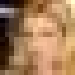

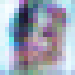

epoch =  73
Epoch [72/500], Step [438/438], d_loss: -4.1220, g_loss: 0.8638, D(x): 3.18, D(G(z)): -1.11


Epoch: 75: 100%|██████████| 438/438 [00:24<00:00, 17.90it/s, D_total_loss=-2.75, G_loss=1.31, fake_score=-1.13, real_score=2.36]


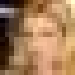

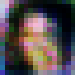

epoch =  75
Epoch [74/500], Step [438/438], d_loss: -2.7548, g_loss: 1.3063, D(x): 2.36, D(G(z)): -1.13


Epoch: 77: 100%|██████████| 438/438 [00:24<00:00, 18.18it/s, D_total_loss=-1.82, G_loss=1.61, fake_score=-.894, real_score=2.23]


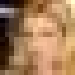

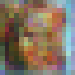

epoch =  77
Epoch [76/500], Step [438/438], d_loss: -1.8246, g_loss: 1.6058, D(x): 2.23, D(G(z)): -0.89


Epoch: 79: 100%|██████████| 438/438 [00:23<00:00, 18.48it/s, D_total_loss=-3.57, G_loss=1.39, fake_score=-1.24, real_score=2.91]


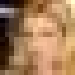

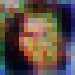

epoch =  79
Epoch [78/500], Step [438/438], d_loss: -3.5666, g_loss: 1.3892, D(x): 2.91, D(G(z)): -1.24


Epoch: 81: 100%|██████████| 438/438 [00:23<00:00, 18.28it/s, D_total_loss=4.41, G_loss=1.52, fake_score=-1.53, real_score=2.39]


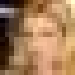

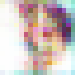

epoch =  81
Epoch [80/500], Step [438/438], d_loss: 4.4052, g_loss: 1.5202, D(x): 2.39, D(G(z)): -1.53


Epoch: 83: 100%|██████████| 438/438 [00:24<00:00, 17.85it/s, D_total_loss=-3.55, G_loss=1.52, fake_score=-1.48, real_score=2.17]


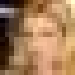

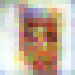

epoch =  83
Epoch [82/500], Step [438/438], d_loss: -3.5479, g_loss: 1.5227, D(x): 2.17, D(G(z)): -1.48


Epoch: 85: 100%|██████████| 438/438 [00:24<00:00, 18.15it/s, D_total_loss=2.42, G_loss=1.56, fake_score=-1.18, real_score=2.64]


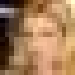

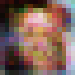

epoch =  85
Epoch [84/500], Step [438/438], d_loss: 2.4188, g_loss: 1.5589, D(x): 2.64, D(G(z)): -1.18


Epoch: 87: 100%|██████████| 438/438 [00:24<00:00, 17.75it/s, D_total_loss=-1.39, G_loss=1.62, fake_score=-1.66, real_score=2.22]


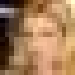

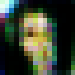

epoch =  87
Epoch [86/500], Step [438/438], d_loss: -1.3870, g_loss: 1.6201, D(x): 2.22, D(G(z)): -1.66


Epoch: 89: 100%|██████████| 438/438 [00:24<00:00, 18.11it/s, D_total_loss=-2.64, G_loss=1.88, fake_score=-.844, real_score=2.53]


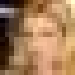

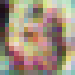

epoch =  89
Epoch [88/500], Step [438/438], d_loss: -2.6373, g_loss: 1.8775, D(x): 2.53, D(G(z)): -0.84


Epoch: 91: 100%|██████████| 438/438 [00:24<00:00, 17.91it/s, D_total_loss=-4.08, G_loss=0.991, fake_score=-1.17, real_score=2.98]


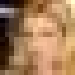

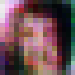

epoch =  91
Epoch [90/500], Step [438/438], d_loss: -4.0787, g_loss: 0.9913, D(x): 2.98, D(G(z)): -1.17


Epoch: 93: 100%|██████████| 438/438 [00:24<00:00, 17.59it/s, D_total_loss=-3.37, G_loss=1.44, fake_score=-.705, real_score=2.8]


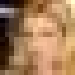

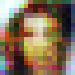

epoch =  93
Epoch [92/500], Step [438/438], d_loss: -3.3730, g_loss: 1.4416, D(x): 2.80, D(G(z)): -0.71


Epoch: 95: 100%|██████████| 438/438 [00:24<00:00, 17.72it/s, D_total_loss=-3.09, G_loss=1.05, fake_score=-1.26, real_score=2.34]


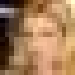

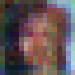

epoch =  95
Epoch [94/500], Step [438/438], d_loss: -3.0941, g_loss: 1.0513, D(x): 2.34, D(G(z)): -1.26


Epoch: 97: 100%|██████████| 438/438 [00:24<00:00, 17.82it/s, D_total_loss=-2.51, G_loss=1.15, fake_score=-1.14, real_score=1.96]


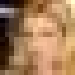

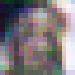

epoch =  97
Epoch [96/500], Step [438/438], d_loss: -2.5130, g_loss: 1.1477, D(x): 1.96, D(G(z)): -1.14


Epoch: 99: 100%|██████████| 438/438 [00:24<00:00, 17.59it/s, D_total_loss=-2.82, G_loss=0.774, fake_score=-.444, real_score=2.51]


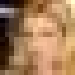

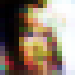

epoch =  99
Epoch [98/500], Step [438/438], d_loss: -2.8154, g_loss: 0.7742, D(x): 2.51, D(G(z)): -0.44


Epoch: 101: 100%|██████████| 438/438 [00:24<00:00, 17.95it/s, D_total_loss=-3.71, G_loss=1.27, fake_score=-.831, real_score=3.01]


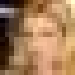

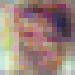

epoch =  101
Epoch [100/500], Step [438/438], d_loss: -3.7073, g_loss: 1.2738, D(x): 3.01, D(G(z)): -0.83


Epoch: 103: 100%|██████████| 438/438 [00:24<00:00, 17.53it/s, D_total_loss=-3.59, G_loss=1.16, fake_score=-1.45, real_score=2.72]


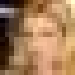

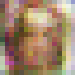

epoch =  103
Epoch [102/500], Step [438/438], d_loss: -3.5922, g_loss: 1.1621, D(x): 2.72, D(G(z)): -1.45


Epoch: 105: 100%|██████████| 438/438 [00:24<00:00, 17.67it/s, D_total_loss=-2.58, G_loss=0.988, fake_score=-.36, real_score=2.52]


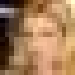

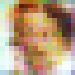

epoch =  105
Epoch [104/500], Step [438/438], d_loss: -2.5800, g_loss: 0.9885, D(x): 2.52, D(G(z)): -0.36


Epoch: 107: 100%|██████████| 438/438 [00:25<00:00, 17.46it/s, D_total_loss=-3.53, G_loss=0.954, fake_score=-1.02, real_score=2.75]


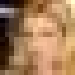

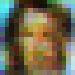

epoch =  107
Epoch [106/500], Step [438/438], d_loss: -3.5315, g_loss: 0.9538, D(x): 2.75, D(G(z)): -1.02


Epoch: 109: 100%|██████████| 438/438 [00:24<00:00, 17.86it/s, D_total_loss=-3.34, G_loss=0.652, fake_score=-.825, real_score=2.73]


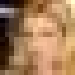

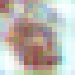

epoch =  109
Epoch [108/500], Step [438/438], d_loss: -3.3386, g_loss: 0.6524, D(x): 2.73, D(G(z)): -0.83


Epoch: 111: 100%|██████████| 438/438 [00:24<00:00, 17.64it/s, D_total_loss=-2.75, G_loss=0.842, fake_score=-1.34, real_score=3.4]


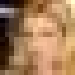

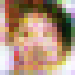

epoch =  111
Epoch [110/500], Step [438/438], d_loss: -2.7504, g_loss: 0.8415, D(x): 3.40, D(G(z)): -1.34


Epoch: 113: 100%|██████████| 438/438 [00:24<00:00, 17.78it/s, D_total_loss=-2.11, G_loss=0.42, fake_score=-.392, real_score=2.74]


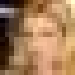

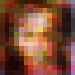

epoch =  113
Epoch [112/500], Step [438/438], d_loss: -2.1058, g_loss: 0.4201, D(x): 2.74, D(G(z)): -0.39


Epoch: 115: 100%|██████████| 438/438 [00:24<00:00, 17.61it/s, D_total_loss=-2.95, G_loss=1.08, fake_score=-.888, real_score=2.26]


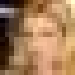

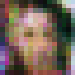

epoch =  115
Epoch [114/500], Step [438/438], d_loss: -2.9502, g_loss: 1.0808, D(x): 2.26, D(G(z)): -0.89


Epoch: 117: 100%|██████████| 438/438 [00:24<00:00, 17.78it/s, D_total_loss=-2.2, G_loss=0.555, fake_score=-.45, real_score=2.39]


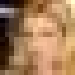

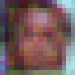

epoch =  117
Epoch [116/500], Step [438/438], d_loss: -2.2003, g_loss: 0.5554, D(x): 2.39, D(G(z)): -0.45


Epoch: 119: 100%|██████████| 438/438 [00:24<00:00, 17.53it/s, D_total_loss=-2.62, G_loss=0.986, fake_score=-1.02, real_score=2.24]


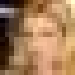

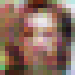

epoch =  119
Epoch [118/500], Step [438/438], d_loss: -2.6194, g_loss: 0.9858, D(x): 2.24, D(G(z)): -1.02


Epoch: 121: 100%|██████████| 438/438 [00:24<00:00, 17.82it/s, D_total_loss=-2.51, G_loss=0.462, fake_score=-.563, real_score=2.19]


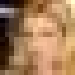

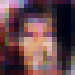

epoch =  121
Epoch [120/500], Step [438/438], d_loss: -2.5117, g_loss: 0.4620, D(x): 2.19, D(G(z)): -0.56


Epoch: 123: 100%|██████████| 438/438 [00:24<00:00, 17.53it/s, D_total_loss=58.6, G_loss=0.406, fake_score=-.169, real_score=2.08]


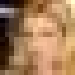

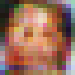

epoch =  123
Epoch [122/500], Step [438/438], d_loss: 58.5896, g_loss: 0.4063, D(x): 2.08, D(G(z)): -0.17


Epoch: 125: 100%|██████████| 438/438 [00:24<00:00, 18.14it/s, D_total_loss=-2.47, G_loss=0.994, fake_score=-.33, real_score=3.29]


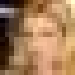

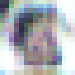

epoch =  125
Epoch [124/500], Step [438/438], d_loss: -2.4704, g_loss: 0.9937, D(x): 3.29, D(G(z)): -0.33


Epoch: 127: 100%|██████████| 438/438 [00:25<00:00, 17.29it/s, D_total_loss=-.391, G_loss=0.649, fake_score=-.376, real_score=1.76]


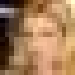

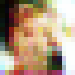

epoch =  127
Epoch [126/500], Step [438/438], d_loss: -0.3911, g_loss: 0.6488, D(x): 1.76, D(G(z)): -0.38


Epoch: 129: 100%|██████████| 438/438 [00:24<00:00, 17.85it/s, D_total_loss=-2.12, G_loss=0.327, fake_score=0.281, real_score=3.01]


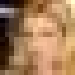

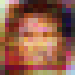

epoch =  129
Epoch [128/500], Step [438/438], d_loss: -2.1202, g_loss: 0.3266, D(x): 3.01, D(G(z)): 0.28


Epoch: 131: 100%|██████████| 438/438 [00:25<00:00, 17.45it/s, D_total_loss=-1.54, G_loss=0.673, fake_score=-.332, real_score=2.25]


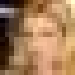

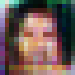

epoch =  131
Epoch [130/500], Step [438/438], d_loss: -1.5444, g_loss: 0.6732, D(x): 2.25, D(G(z)): -0.33


Epoch: 133: 100%|██████████| 438/438 [00:24<00:00, 17.69it/s, D_total_loss=-.993, G_loss=1.05, fake_score=0.148, real_score=2.65]


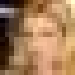

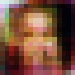

epoch =  133
Epoch [132/500], Step [438/438], d_loss: -0.9926, g_loss: 1.0550, D(x): 2.65, D(G(z)): 0.15


Epoch: 135: 100%|██████████| 438/438 [00:25<00:00, 17.38it/s, D_total_loss=-2.52, G_loss=0.0181, fake_score=0.0828, real_score=2.82]


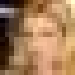

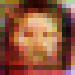

epoch =  135
Epoch [134/500], Step [438/438], d_loss: -2.5178, g_loss: 0.0181, D(x): 2.82, D(G(z)): 0.08


Epoch: 137: 100%|██████████| 438/438 [00:24<00:00, 17.57it/s, D_total_loss=2.82, G_loss=0.755, fake_score=-.504, real_score=2.25]


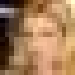

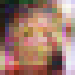

epoch =  137
Epoch [136/500], Step [438/438], d_loss: 2.8196, g_loss: 0.7551, D(x): 2.25, D(G(z)): -0.50


Epoch: 139: 100%|██████████| 438/438 [00:25<00:00, 17.27it/s, D_total_loss=-2.59, G_loss=0.586, fake_score=-.79, real_score=1.93]


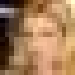

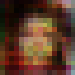

epoch =  139
Epoch [138/500], Step [438/438], d_loss: -2.5942, g_loss: 0.5863, D(x): 1.93, D(G(z)): -0.79


Epoch: 141: 100%|██████████| 438/438 [00:25<00:00, 17.44it/s, D_total_loss=-3.25, G_loss=-.0805, fake_score=-.391, real_score=2.96]


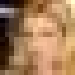

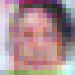

epoch =  141
Epoch [140/500], Step [438/438], d_loss: -3.2531, g_loss: -0.0805, D(x): 2.96, D(G(z)): -0.39


Epoch: 143: 100%|██████████| 438/438 [00:25<00:00, 17.24it/s, D_total_loss=-2.01, G_loss=0.811, fake_score=-.0963, real_score=2.05]


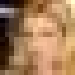

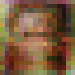

epoch =  143
Epoch [142/500], Step [438/438], d_loss: -2.0073, g_loss: 0.8108, D(x): 2.05, D(G(z)): -0.10


Epoch: 145: 100%|██████████| 438/438 [00:25<00:00, 17.42it/s, D_total_loss=-3.09, G_loss=0.57, fake_score=-.395, real_score=2.82]


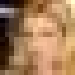

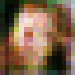

epoch =  145
Epoch [144/500], Step [438/438], d_loss: -3.0934, g_loss: 0.5700, D(x): 2.82, D(G(z)): -0.40


Epoch: 147: 100%|██████████| 438/438 [00:24<00:00, 17.55it/s, D_total_loss=-3.11, G_loss=-.0412, fake_score=-.754, real_score=2.49]


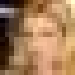

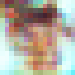

epoch =  147
Epoch [146/500], Step [438/438], d_loss: -3.1115, g_loss: -0.0412, D(x): 2.49, D(G(z)): -0.75


Epoch: 149: 100%|██████████| 438/438 [00:25<00:00, 17.40it/s, D_total_loss=1.17, G_loss=0.129, fake_score=-.941, real_score=3]


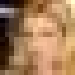

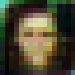

epoch =  149
Epoch [148/500], Step [438/438], d_loss: 1.1658, g_loss: 0.1286, D(x): 3.00, D(G(z)): -0.94


Epoch: 151: 100%|██████████| 438/438 [00:25<00:00, 17.41it/s, D_total_loss=-3.36, G_loss=0.0809, fake_score=-.289, real_score=3.23]


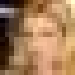

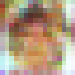

epoch =  151
Epoch [150/500], Step [438/438], d_loss: -3.3620, g_loss: 0.0809, D(x): 3.23, D(G(z)): -0.29


Epoch: 153: 100%|██████████| 438/438 [00:25<00:00, 17.04it/s, D_total_loss=1.66, G_loss=0.022, fake_score=-.498, real_score=2.86]


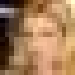

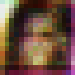

epoch =  153
Epoch [152/500], Step [438/438], d_loss: 1.6617, g_loss: 0.0220, D(x): 2.86, D(G(z)): -0.50


Epoch: 155: 100%|██████████| 438/438 [00:25<00:00, 17.25it/s, D_total_loss=-1.94, G_loss=-.586, fake_score=1.05, real_score=3.11]


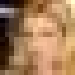

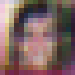

epoch =  155
Epoch [154/500], Step [438/438], d_loss: -1.9359, g_loss: -0.5861, D(x): 3.11, D(G(z)): 1.05


Epoch: 157: 100%|██████████| 438/438 [00:25<00:00, 17.00it/s, D_total_loss=-3.2, G_loss=0.15, fake_score=0.0191, real_score=3.32]


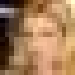

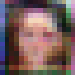

epoch =  157
Epoch [156/500], Step [438/438], d_loss: -3.1959, g_loss: 0.1501, D(x): 3.32, D(G(z)): 0.02


Epoch: 159: 100%|██████████| 438/438 [00:25<00:00, 17.09it/s, D_total_loss=-1.84, G_loss=-.596, fake_score=0.505, real_score=2.93]


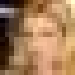

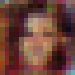

epoch =  159
Epoch [158/500], Step [438/438], d_loss: -1.8403, g_loss: -0.5959, D(x): 2.93, D(G(z)): 0.50


Epoch: 161: 100%|██████████| 438/438 [00:25<00:00, 17.15it/s, D_total_loss=-2.02, G_loss=0.00548, fake_score=0.612, real_score=2.91]


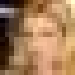

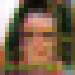

epoch =  161
Epoch [160/500], Step [438/438], d_loss: -2.0151, g_loss: 0.0055, D(x): 2.91, D(G(z)): 0.61


Epoch: 163: 100%|██████████| 438/438 [00:25<00:00, 17.14it/s, D_total_loss=-3.33, G_loss=-.947, fake_score=0.325, real_score=3.74]


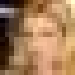

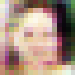

epoch =  163
Epoch [162/500], Step [438/438], d_loss: -3.3257, g_loss: -0.9475, D(x): 3.74, D(G(z)): 0.32


Epoch: 165: 100%|██████████| 438/438 [00:25<00:00, 17.15it/s, D_total_loss=-3.18, G_loss=0.116, fake_score=0.252, real_score=3.59]


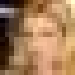

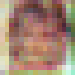

epoch =  165
Epoch [164/500], Step [438/438], d_loss: -3.1807, g_loss: 0.1161, D(x): 3.59, D(G(z)): 0.25


Epoch: 167: 100%|██████████| 438/438 [00:25<00:00, 16.96it/s, D_total_loss=-2.48, G_loss=-.546, fake_score=0.149, real_score=2.78]


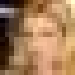

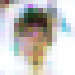

epoch =  167
Epoch [166/500], Step [438/438], d_loss: -2.4774, g_loss: -0.5465, D(x): 2.78, D(G(z)): 0.15


Epoch: 169: 100%|██████████| 438/438 [00:24<00:00, 17.56it/s, D_total_loss=-2.58, G_loss=-.916, fake_score=1.07, real_score=3.72]


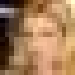

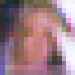

epoch =  169
Epoch [168/500], Step [438/438], d_loss: -2.5798, g_loss: -0.9163, D(x): 3.72, D(G(z)): 1.07


Epoch: 171: 100%|██████████| 438/438 [00:24<00:00, 17.71it/s, D_total_loss=-3.16, G_loss=-.257, fake_score=-.0471, real_score=3.2]


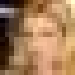

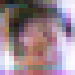

epoch =  171
Epoch [170/500], Step [438/438], d_loss: -3.1605, g_loss: -0.2567, D(x): 3.20, D(G(z)): -0.05


Epoch: 173: 100%|██████████| 438/438 [00:25<00:00, 17.33it/s, D_total_loss=-2.6, G_loss=-.715, fake_score=0.893, real_score=3.63]


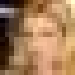

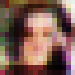

epoch =  173
Epoch [172/500], Step [438/438], d_loss: -2.5955, g_loss: -0.7148, D(x): 3.63, D(G(z)): 0.89


Epoch: 175: 100%|██████████| 438/438 [00:25<00:00, 17.44it/s, D_total_loss=6.91, G_loss=-.389, fake_score=0.793, real_score=3.69]


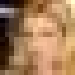

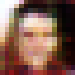

epoch =  175
Epoch [174/500], Step [438/438], d_loss: 6.9073, g_loss: -0.3886, D(x): 3.69, D(G(z)): 0.79


Epoch: 177: 100%|██████████| 438/438 [00:24<00:00, 17.74it/s, D_total_loss=3.93, G_loss=-.976, fake_score=1.13, real_score=4.64]


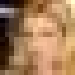

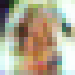

epoch =  177
Epoch [176/500], Step [438/438], d_loss: 3.9292, g_loss: -0.9760, D(x): 4.64, D(G(z)): 1.13


Epoch: 179: 100%|██████████| 438/438 [00:24<00:00, 17.54it/s, D_total_loss=-2.75, G_loss=-.136, fake_score=1.06, real_score=4.01]


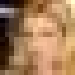

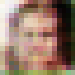

epoch =  179
Epoch [178/500], Step [438/438], d_loss: -2.7550, g_loss: -0.1363, D(x): 4.01, D(G(z)): 1.06


Epoch: 181: 100%|██████████| 438/438 [00:26<00:00, 16.83it/s, D_total_loss=-3.63, G_loss=-.845, fake_score=0.542, real_score=4.23]


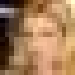

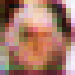

epoch =  181
Epoch [180/500], Step [438/438], d_loss: -3.6251, g_loss: -0.8454, D(x): 4.23, D(G(z)): 0.54


Epoch: 183: 100%|██████████| 438/438 [00:25<00:00, 17.10it/s, D_total_loss=-4.19, G_loss=-1.31, fake_score=0.644, real_score=5.04]


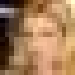

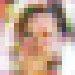

epoch =  183
Epoch [182/500], Step [438/438], d_loss: -4.1929, g_loss: -1.3128, D(x): 5.04, D(G(z)): 0.64


Epoch: 185: 100%|██████████| 438/438 [00:24<00:00, 17.57it/s, D_total_loss=-2.9, G_loss=-1.17, fake_score=0.987, real_score=4.52]


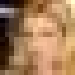

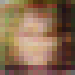

epoch =  185
Epoch [184/500], Step [438/438], d_loss: -2.9018, g_loss: -1.1655, D(x): 4.52, D(G(z)): 0.99


Epoch: 187: 100%|██████████| 438/438 [00:24<00:00, 17.59it/s, D_total_loss=-2.79, G_loss=-1.06, fake_score=1.09, real_score=5.14]


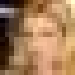

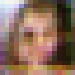

epoch =  187
Epoch [186/500], Step [438/438], d_loss: -2.7930, g_loss: -1.0630, D(x): 5.14, D(G(z)): 1.09


Epoch: 189: 100%|██████████| 438/438 [00:25<00:00, 17.38it/s, D_total_loss=-3.86, G_loss=-.672, fake_score=1.04, real_score=5.07]


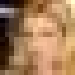

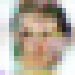

epoch =  189
Epoch [188/500], Step [438/438], d_loss: -3.8574, g_loss: -0.6715, D(x): 5.07, D(G(z)): 1.04


Epoch: 191: 100%|██████████| 438/438 [00:25<00:00, 17.03it/s, D_total_loss=-1.73, G_loss=-1.49, fake_score=1.34, real_score=4.55]


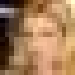

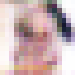

epoch =  191
Epoch [190/500], Step [438/438], d_loss: -1.7266, g_loss: -1.4913, D(x): 4.55, D(G(z)): 1.34


Epoch: 193: 100%|██████████| 438/438 [00:25<00:00, 17.25it/s, D_total_loss=-3.58, G_loss=-.964, fake_score=1.24, real_score=4.92]


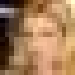

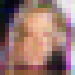

epoch =  193
Epoch [192/500], Step [438/438], d_loss: -3.5823, g_loss: -0.9641, D(x): 4.92, D(G(z)): 1.24


Epoch: 195: 100%|██████████| 438/438 [00:25<00:00, 17.00it/s, D_total_loss=-3.24, G_loss=-.981, fake_score=1.46, real_score=4.84]


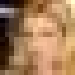

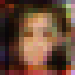

epoch =  195
Epoch [194/500], Step [438/438], d_loss: -3.2443, g_loss: -0.9805, D(x): 4.84, D(G(z)): 1.46


Epoch: 197: 100%|██████████| 438/438 [00:25<00:00, 17.34it/s, D_total_loss=-3.52, G_loss=-1.41, fake_score=1.39, real_score=5.07]


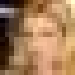

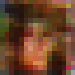

epoch =  197
Epoch [196/500], Step [438/438], d_loss: -3.5245, g_loss: -1.4083, D(x): 5.07, D(G(z)): 1.39


Epoch: 199: 100%|██████████| 438/438 [00:25<00:00, 17.38it/s, D_total_loss=-3.39, G_loss=-1.32, fake_score=1.36, real_score=5.35]


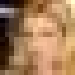

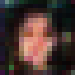

epoch =  199
Epoch [198/500], Step [438/438], d_loss: -3.3918, g_loss: -1.3204, D(x): 5.35, D(G(z)): 1.36


Epoch: 201: 100%|██████████| 438/438 [00:26<00:00, 16.69it/s, D_total_loss=-2.94, G_loss=-1.55, fake_score=1.77, real_score=5.17]


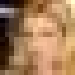

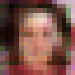

epoch =  201
Epoch [200/500], Step [438/438], d_loss: -2.9373, g_loss: -1.5508, D(x): 5.17, D(G(z)): 1.77


Epoch: 203: 100%|██████████| 438/438 [00:25<00:00, 16.90it/s, D_total_loss=-4.05, G_loss=-1.39, fake_score=1.64, real_score=5.77]


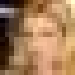

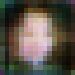

epoch =  203
Epoch [202/500], Step [438/438], d_loss: -4.0472, g_loss: -1.3876, D(x): 5.77, D(G(z)): 1.64


Epoch: 205: 100%|██████████| 438/438 [00:25<00:00, 17.03it/s, D_total_loss=-3.94, G_loss=-1.37, fake_score=1.7, real_score=5.72]


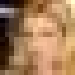

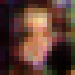

epoch =  205
Epoch [204/500], Step [438/438], d_loss: -3.9448, g_loss: -1.3673, D(x): 5.72, D(G(z)): 1.70


Epoch: 207: 100%|██████████| 438/438 [00:25<00:00, 17.35it/s, D_total_loss=-3.9, G_loss=-1.58, fake_score=1.69, real_score=5.68]


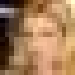

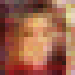

epoch =  207
Epoch [206/500], Step [438/438], d_loss: -3.9034, g_loss: -1.5779, D(x): 5.68, D(G(z)): 1.69


Epoch: 209: 100%|██████████| 438/438 [00:25<00:00, 16.93it/s, D_total_loss=-4.32, G_loss=-1.58, fake_score=1.24, real_score=5.82]


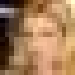

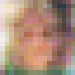

epoch =  209
Epoch [208/500], Step [438/438], d_loss: -4.3239, g_loss: -1.5809, D(x): 5.82, D(G(z)): 1.24


Epoch: 211: 100%|██████████| 438/438 [00:25<00:00, 17.41it/s, D_total_loss=-2.03, G_loss=-1.5, fake_score=2.37, real_score=5.53]


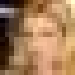

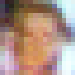

epoch =  211
Epoch [210/500], Step [438/438], d_loss: -2.0307, g_loss: -1.5005, D(x): 5.53, D(G(z)): 2.37


Epoch: 213: 100%|██████████| 438/438 [00:25<00:00, 17.08it/s, D_total_loss=-4.83, G_loss=-1.2, fake_score=1.44, real_score=6.61]


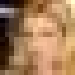

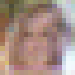

epoch =  213
Epoch [212/500], Step [438/438], d_loss: -4.8331, g_loss: -1.1970, D(x): 6.61, D(G(z)): 1.44


Epoch: 215: 100%|██████████| 438/438 [00:26<00:00, 16.77it/s, D_total_loss=-3.87, G_loss=-.774, fake_score=1.98, real_score=5.96]


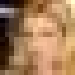

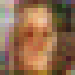

epoch =  215
Epoch [214/500], Step [438/438], d_loss: -3.8737, g_loss: -0.7737, D(x): 5.96, D(G(z)): 1.98


Epoch: 217: 100%|██████████| 438/438 [00:25<00:00, 16.85it/s, D_total_loss=-3.91, G_loss=-1.19, fake_score=2.01, real_score=6.04]


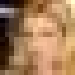

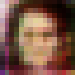

epoch =  217
Epoch [216/500], Step [438/438], d_loss: -3.9132, g_loss: -1.1879, D(x): 6.04, D(G(z)): 2.01


Epoch: 219: 100%|██████████| 438/438 [00:25<00:00, 17.01it/s, D_total_loss=-5.78, G_loss=-1.1, fake_score=0.93, real_score=6.84]


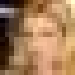

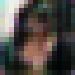

epoch =  219
Epoch [218/500], Step [438/438], d_loss: -5.7831, g_loss: -1.1004, D(x): 6.84, D(G(z)): 0.93


Epoch: 221: 100%|██████████| 438/438 [00:25<00:00, 16.88it/s, D_total_loss=-4.27, G_loss=-1.99, fake_score=2.18, real_score=6.69]


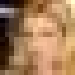

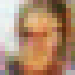

epoch =  221
Epoch [220/500], Step [438/438], d_loss: -4.2661, g_loss: -1.9868, D(x): 6.69, D(G(z)): 2.18


Epoch: 223: 100%|██████████| 438/438 [00:25<00:00, 17.01it/s, D_total_loss=-2.8, G_loss=-1.57, fake_score=1.52, real_score=6.77]


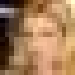

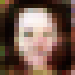

epoch =  223
Epoch [222/500], Step [438/438], d_loss: -2.7996, g_loss: -1.5741, D(x): 6.77, D(G(z)): 1.52


Epoch: 225: 100%|██████████| 438/438 [00:26<00:00, 16.81it/s, D_total_loss=-4.59, G_loss=-1.48, fake_score=1.5, real_score=6.74]


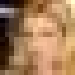

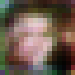

epoch =  225
Epoch [224/500], Step [438/438], d_loss: -4.5924, g_loss: -1.4793, D(x): 6.74, D(G(z)): 1.50


Epoch: 227: 100%|██████████| 438/438 [00:26<00:00, 16.46it/s, D_total_loss=-5.12, G_loss=-1.48, fake_score=1.07, real_score=6.3]


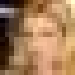

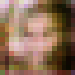

epoch =  227
Epoch [226/500], Step [438/438], d_loss: -5.1231, g_loss: -1.4767, D(x): 6.30, D(G(z)): 1.07


Epoch: 229: 100%|██████████| 438/438 [00:26<00:00, 16.49it/s, D_total_loss=-4.79, G_loss=-1.22, fake_score=1.57, real_score=6.47]


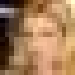

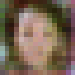

epoch =  229
Epoch [228/500], Step [438/438], d_loss: -4.7877, g_loss: -1.2222, D(x): 6.47, D(G(z)): 1.57


Epoch: 231: 100%|██████████| 438/438 [00:25<00:00, 17.17it/s, D_total_loss=-4.71, G_loss=-1.24, fake_score=1.63, real_score=6.57]


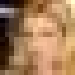

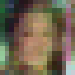

epoch =  231
Epoch [230/500], Step [438/438], d_loss: -4.7097, g_loss: -1.2409, D(x): 6.57, D(G(z)): 1.63


Epoch: 233: 100%|██████████| 438/438 [00:25<00:00, 16.89it/s, D_total_loss=-4.7, G_loss=-1.29, fake_score=2.18, real_score=6.93]


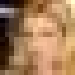

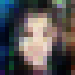

epoch =  233
Epoch [232/500], Step [438/438], d_loss: -4.6958, g_loss: -1.2851, D(x): 6.93, D(G(z)): 2.18


Epoch: 235: 100%|██████████| 438/438 [00:25<00:00, 17.10it/s, D_total_loss=-4.65, G_loss=-1.95, fake_score=1.68, real_score=6.47]


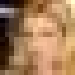

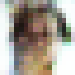

epoch =  235
Epoch [234/500], Step [438/438], d_loss: -4.6453, g_loss: -1.9508, D(x): 6.47, D(G(z)): 1.68


Epoch: 237: 100%|██████████| 438/438 [00:25<00:00, 17.28it/s, D_total_loss=-4.89, G_loss=-1.6, fake_score=1.71, real_score=6.85]


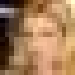

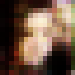

epoch =  237
Epoch [236/500], Step [438/438], d_loss: -4.8945, g_loss: -1.5985, D(x): 6.85, D(G(z)): 1.71


Epoch: 239: 100%|██████████| 438/438 [00:26<00:00, 16.65it/s, D_total_loss=0.632, G_loss=-1.29, fake_score=1.6, real_score=6.54]


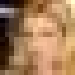

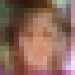

epoch =  239
Epoch [238/500], Step [438/438], d_loss: 0.6324, g_loss: -1.2864, D(x): 6.54, D(G(z)): 1.60


Epoch: 241: 100%|██████████| 438/438 [00:25<00:00, 16.86it/s, D_total_loss=-6.06, G_loss=-1.7, fake_score=1.22, real_score=7.42]


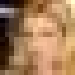

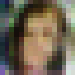

epoch =  241
Epoch [240/500], Step [438/438], d_loss: -6.0597, g_loss: -1.7007, D(x): 7.42, D(G(z)): 1.22


Epoch: 243: 100%|██████████| 438/438 [00:25<00:00, 16.90it/s, D_total_loss=-3.92, G_loss=-1.26, fake_score=1.59, real_score=7.49]


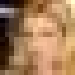

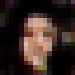

epoch =  243
Epoch [242/500], Step [438/438], d_loss: -3.9214, g_loss: -1.2559, D(x): 7.49, D(G(z)): 1.59


Epoch: 245: 100%|██████████| 438/438 [00:26<00:00, 16.60it/s, D_total_loss=-5.89, G_loss=-1.37, fake_score=1.83, real_score=7.81]


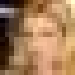

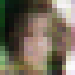

epoch =  245
Epoch [244/500], Step [438/438], d_loss: -5.8900, g_loss: -1.3745, D(x): 7.81, D(G(z)): 1.83


Epoch: 247: 100%|██████████| 438/438 [00:26<00:00, 16.75it/s, D_total_loss=-4.11, G_loss=-1.21, fake_score=1.65, real_score=6.9]


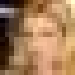

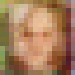

epoch =  247
Epoch [246/500], Step [438/438], d_loss: -4.1136, g_loss: -1.2065, D(x): 6.90, D(G(z)): 1.65


Epoch: 249: 100%|██████████| 438/438 [00:26<00:00, 16.47it/s, D_total_loss=-6.35, G_loss=-1.27, fake_score=1.08, real_score=7.54]


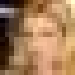

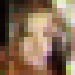

epoch =  249
Epoch [248/500], Step [438/438], d_loss: -6.3495, g_loss: -1.2657, D(x): 7.54, D(G(z)): 1.08


Epoch: 251: 100%|██████████| 438/438 [00:26<00:00, 16.54it/s, D_total_loss=-6.67, G_loss=-1.23, fake_score=0.737, real_score=7.63]


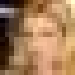

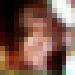

epoch =  251
Epoch [250/500], Step [438/438], d_loss: -6.6667, g_loss: -1.2279, D(x): 7.63, D(G(z)): 0.74


Epoch: 253: 100%|██████████| 438/438 [00:26<00:00, 16.49it/s, D_total_loss=-1.3, G_loss=-.916, fake_score=1.54, real_score=7.26]


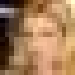

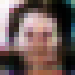

epoch =  253
Epoch [252/500], Step [438/438], d_loss: -1.3026, g_loss: -0.9162, D(x): 7.26, D(G(z)): 1.54


Epoch: 255: 100%|██████████| 438/438 [00:26<00:00, 16.73it/s, D_total_loss=5.64, G_loss=-.78, fake_score=0.843, real_score=8.13]


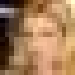

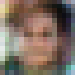

epoch =  255
Epoch [254/500], Step [438/438], d_loss: 5.6393, g_loss: -0.7796, D(x): 8.13, D(G(z)): 0.84


Epoch: 257: 100%|██████████| 438/438 [00:26<00:00, 16.53it/s, D_total_loss=3.74, G_loss=-.827, fake_score=1.8, real_score=8.07]


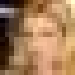

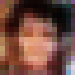

epoch =  257
Epoch [256/500], Step [438/438], d_loss: 3.7436, g_loss: -0.8271, D(x): 8.07, D(G(z)): 1.80


Epoch: 259: 100%|██████████| 438/438 [00:26<00:00, 16.44it/s, D_total_loss=-6.7, G_loss=-1.96, fake_score=1.24, real_score=8.17]


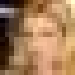

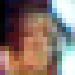

epoch =  259
Epoch [258/500], Step [438/438], d_loss: -6.6959, g_loss: -1.9626, D(x): 8.17, D(G(z)): 1.24


Epoch: 261: 100%|██████████| 438/438 [00:26<00:00, 16.72it/s, D_total_loss=-7.1, G_loss=-.918, fake_score=0.65, real_score=7.81]


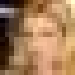

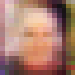

epoch =  261
Epoch [260/500], Step [438/438], d_loss: -7.1020, g_loss: -0.9178, D(x): 7.81, D(G(z)): 0.65


Epoch: 263: 100%|██████████| 438/438 [00:26<00:00, 16.39it/s, D_total_loss=-6.65, G_loss=-1.15, fake_score=1.11, real_score=8.43]


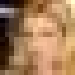

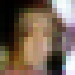

epoch =  263
Epoch [262/500], Step [438/438], d_loss: -6.6484, g_loss: -1.1484, D(x): 8.43, D(G(z)): 1.11


Epoch: 265: 100%|██████████| 438/438 [00:26<00:00, 16.41it/s, D_total_loss=-4.58, G_loss=-1.63, fake_score=1.37, real_score=7.74]


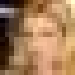

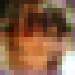

epoch =  265
Epoch [264/500], Step [438/438], d_loss: -4.5847, g_loss: -1.6328, D(x): 7.74, D(G(z)): 1.37


Epoch: 267: 100%|██████████| 438/438 [00:26<00:00, 16.55it/s, D_total_loss=-5.88, G_loss=-.974, fake_score=1.33, real_score=8.91]


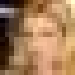

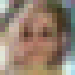

epoch =  267
Epoch [266/500], Step [438/438], d_loss: -5.8762, g_loss: -0.9735, D(x): 8.91, D(G(z)): 1.33


Epoch: 269: 100%|██████████| 438/438 [00:27<00:00, 16.09it/s, D_total_loss=-6.56, G_loss=-.758, fake_score=1.64, real_score=8.28]


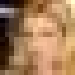

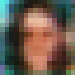

epoch =  269
Epoch [268/500], Step [438/438], d_loss: -6.5554, g_loss: -0.7583, D(x): 8.28, D(G(z)): 1.64


Epoch: 271: 100%|██████████| 438/438 [00:27<00:00, 16.07it/s, D_total_loss=-7.66, G_loss=-1.01, fake_score=0.854, real_score=8.75]


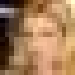

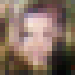

epoch =  271
Epoch [270/500], Step [438/438], d_loss: -7.6589, g_loss: -1.0125, D(x): 8.75, D(G(z)): 0.85


Epoch: 273: 100%|██████████| 438/438 [00:27<00:00, 16.06it/s, D_total_loss=-6.34, G_loss=-1.19, fake_score=2.04, real_score=8.59]


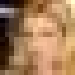

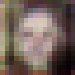

epoch =  273
Epoch [272/500], Step [438/438], d_loss: -6.3374, g_loss: -1.1852, D(x): 8.59, D(G(z)): 2.04


Epoch: 275: 100%|██████████| 438/438 [00:27<00:00, 15.95it/s, D_total_loss=169, G_loss=-.637, fake_score=0.615, real_score=8.8]


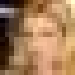

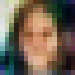

epoch =  275
Epoch [274/500], Step [438/438], d_loss: 168.9745, g_loss: -0.6373, D(x): 8.80, D(G(z)): 0.62


Epoch: 277: 100%|██████████| 438/438 [00:27<00:00, 15.91it/s, D_total_loss=-6.72, G_loss=-.744, fake_score=1.52, real_score=8.34]


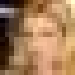

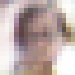

epoch =  277
Epoch [276/500], Step [438/438], d_loss: -6.7208, g_loss: -0.7444, D(x): 8.34, D(G(z)): 1.52


Epoch: 279: 100%|██████████| 438/438 [00:27<00:00, 15.87it/s, D_total_loss=-7.14, G_loss=-1.42, fake_score=1.34, real_score=8.63]


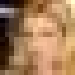

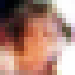

epoch =  279
Epoch [278/500], Step [438/438], d_loss: -7.1385, g_loss: -1.4181, D(x): 8.63, D(G(z)): 1.34


Epoch: 281: 100%|██████████| 438/438 [00:27<00:00, 16.21it/s, D_total_loss=-6.27, G_loss=-1.07, fake_score=0.762, real_score=8.14]


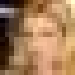

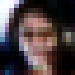

epoch =  281
Epoch [280/500], Step [438/438], d_loss: -6.2702, g_loss: -1.0675, D(x): 8.14, D(G(z)): 0.76


Epoch: 283: 100%|██████████| 438/438 [00:27<00:00, 16.08it/s, D_total_loss=-8.05, G_loss=-1.24, fake_score=1.28, real_score=9.53]


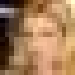

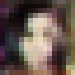

epoch =  283
Epoch [282/500], Step [438/438], d_loss: -8.0547, g_loss: -1.2372, D(x): 9.53, D(G(z)): 1.28


Epoch: 285: 100%|██████████| 438/438 [00:27<00:00, 15.93it/s, D_total_loss=-5.94, G_loss=-1.5, fake_score=1.67, real_score=7.7]


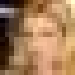

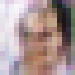

epoch =  285
Epoch [284/500], Step [438/438], d_loss: -5.9416, g_loss: -1.4979, D(x): 7.70, D(G(z)): 1.67


Epoch: 287: 100%|██████████| 438/438 [00:26<00:00, 16.24it/s, D_total_loss=-8.29, G_loss=-1.51, fake_score=0.132, real_score=8.65]


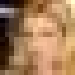

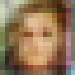

epoch =  287
Epoch [286/500], Step [438/438], d_loss: -8.2904, g_loss: -1.5058, D(x): 8.65, D(G(z)): 0.13


Epoch: 289: 100%|██████████| 438/438 [00:27<00:00, 16.22it/s, D_total_loss=-7.5, G_loss=-1.11, fake_score=0.7, real_score=8.55]


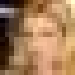

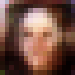

epoch =  289
Epoch [288/500], Step [438/438], d_loss: -7.4988, g_loss: -1.1060, D(x): 8.55, D(G(z)): 0.70


Epoch: 291: 100%|██████████| 438/438 [00:26<00:00, 16.33it/s, D_total_loss=-6.86, G_loss=-1.15, fake_score=0.504, real_score=8.48]


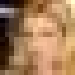

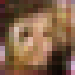

epoch =  291
Epoch [290/500], Step [438/438], d_loss: -6.8619, g_loss: -1.1508, D(x): 8.48, D(G(z)): 0.50


Epoch: 293: 100%|██████████| 438/438 [00:27<00:00, 16.15it/s, D_total_loss=-7.97, G_loss=-.623, fake_score=0.671, real_score=9.19]


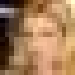

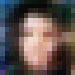

epoch =  293
Epoch [292/500], Step [438/438], d_loss: -7.9749, g_loss: -0.6228, D(x): 9.19, D(G(z)): 0.67


Epoch: 295: 100%|██████████| 438/438 [00:26<00:00, 16.39it/s, D_total_loss=-9.32, G_loss=-.816, fake_score=0.586, real_score=10.1]


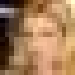

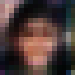

epoch =  295
Epoch [294/500], Step [438/438], d_loss: -9.3236, g_loss: -0.8159, D(x): 10.06, D(G(z)): 0.59


Epoch: 297: 100%|██████████| 438/438 [00:27<00:00, 16.00it/s, D_total_loss=-5.89, G_loss=-1.27, fake_score=0.902, real_score=10.3]


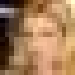

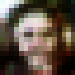

epoch =  297
Epoch [296/500], Step [438/438], d_loss: -5.8898, g_loss: -1.2697, D(x): 10.35, D(G(z)): 0.90


Epoch: 299: 100%|██████████| 438/438 [00:26<00:00, 16.38it/s, D_total_loss=4.83, G_loss=-.583, fake_score=1.21, real_score=9.6]


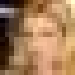

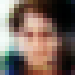

epoch =  299
Epoch [298/500], Step [438/438], d_loss: 4.8346, g_loss: -0.5827, D(x): 9.60, D(G(z)): 1.21


Epoch: 301: 100%|██████████| 438/438 [00:27<00:00, 16.02it/s, D_total_loss=40.6, G_loss=-1.26, fake_score=-.293, real_score=9.61]


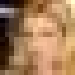

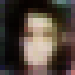

epoch =  301
Epoch [300/500], Step [438/438], d_loss: 40.5695, g_loss: -1.2624, D(x): 9.61, D(G(z)): -0.29


Epoch: 303: 100%|██████████| 438/438 [00:27<00:00, 16.07it/s, D_total_loss=-8.09, G_loss=-.686, fake_score=1.44, real_score=9.75]


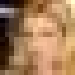

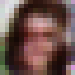

epoch =  303
Epoch [302/500], Step [438/438], d_loss: -8.0856, g_loss: -0.6857, D(x): 9.75, D(G(z)): 1.44


Epoch: 305: 100%|██████████| 438/438 [00:27<00:00, 16.17it/s, D_total_loss=-7.9, G_loss=-.43, fake_score=1.08, real_score=9.19]


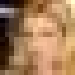

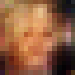

epoch =  305
Epoch [304/500], Step [438/438], d_loss: -7.8970, g_loss: -0.4296, D(x): 9.19, D(G(z)): 1.08


Epoch: 307: 100%|██████████| 438/438 [00:27<00:00, 16.06it/s, D_total_loss=-8.65, G_loss=-.842, fake_score=0.955, real_score=9.77]


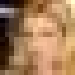

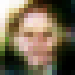

epoch =  307
Epoch [306/500], Step [438/438], d_loss: -8.6467, g_loss: -0.8422, D(x): 9.77, D(G(z)): 0.96


Epoch: 309: 100%|██████████| 438/438 [00:27<00:00, 15.84it/s, D_total_loss=-4.72, G_loss=-1.23, fake_score=1.14, real_score=9.08]


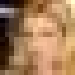

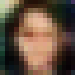

epoch =  309
Epoch [308/500], Step [438/438], d_loss: -4.7196, g_loss: -1.2285, D(x): 9.08, D(G(z)): 1.14


Epoch: 311: 100%|██████████| 438/438 [00:27<00:00, 16.13it/s, D_total_loss=-8.36, G_loss=-1.04, fake_score=0.538, real_score=9]


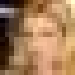

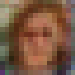

epoch =  311
Epoch [310/500], Step [438/438], d_loss: -8.3575, g_loss: -1.0356, D(x): 9.00, D(G(z)): 0.54


Epoch: 313: 100%|██████████| 438/438 [00:27<00:00, 16.05it/s, D_total_loss=-10.4, G_loss=-1.64, fake_score=0.0872, real_score=10.6]


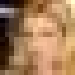

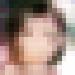

epoch =  313
Epoch [312/500], Step [438/438], d_loss: -10.3573, g_loss: -1.6366, D(x): 10.60, D(G(z)): 0.09


Epoch: 315: 100%|██████████| 438/438 [00:27<00:00, 16.10it/s, D_total_loss=-7.47, G_loss=-.744, fake_score=2.01, real_score=10.1]


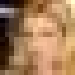

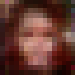

epoch =  315
Epoch [314/500], Step [438/438], d_loss: -7.4706, g_loss: -0.7442, D(x): 10.14, D(G(z)): 2.01


Epoch: 317: 100%|██████████| 438/438 [00:27<00:00, 15.96it/s, D_total_loss=-8.38, G_loss=-1.65, fake_score=1.24, real_score=10.3]


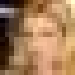

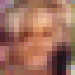

epoch =  317
Epoch [316/500], Step [438/438], d_loss: -8.3846, g_loss: -1.6475, D(x): 10.32, D(G(z)): 1.24


Epoch: 319: 100%|██████████| 438/438 [00:27<00:00, 15.97it/s, D_total_loss=-9.51, G_loss=-.757, fake_score=0.419, real_score=10]


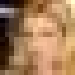

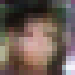

epoch =  319
Epoch [318/500], Step [438/438], d_loss: -9.5081, g_loss: -0.7573, D(x): 10.04, D(G(z)): 0.42


Epoch: 321: 100%|██████████| 438/438 [00:27<00:00, 16.08it/s, D_total_loss=-8.64, G_loss=-.919, fake_score=1.28, real_score=10.4]


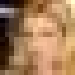

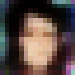

epoch =  321
Epoch [320/500], Step [438/438], d_loss: -8.6367, g_loss: -0.9194, D(x): 10.35, D(G(z)): 1.28


Epoch: 323: 100%|██████████| 438/438 [00:27<00:00, 16.15it/s, D_total_loss=-9.67, G_loss=-.947, fake_score=0.687, real_score=10.5]


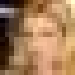

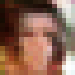

epoch =  323
Epoch [322/500], Step [438/438], d_loss: -9.6659, g_loss: -0.9472, D(x): 10.51, D(G(z)): 0.69


Epoch: 325: 100%|██████████| 438/438 [00:27<00:00, 15.87it/s, D_total_loss=-4.86, G_loss=-1.03, fake_score=1.96, real_score=10.7]


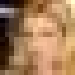

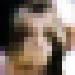

epoch =  325
Epoch [324/500], Step [438/438], d_loss: -4.8592, g_loss: -1.0258, D(x): 10.74, D(G(z)): 1.96


Epoch: 327: 100%|██████████| 438/438 [00:27<00:00, 16.02it/s, D_total_loss=-9.47, G_loss=-1.18, fake_score=0.521, real_score=10.3]


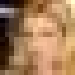

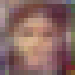

epoch =  327
Epoch [326/500], Step [438/438], d_loss: -9.4709, g_loss: -1.1843, D(x): 10.28, D(G(z)): 0.52


Epoch: 329: 100%|██████████| 438/438 [00:27<00:00, 15.82it/s, D_total_loss=-8.08, G_loss=-1.11, fake_score=1.65, real_score=10.4]


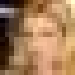

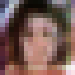

epoch =  329
Epoch [328/500], Step [438/438], d_loss: -8.0796, g_loss: -1.1123, D(x): 10.40, D(G(z)): 1.65


Epoch: 331: 100%|██████████| 438/438 [00:27<00:00, 15.95it/s, D_total_loss=-7.03, G_loss=-.558, fake_score=1.22, real_score=10.1]


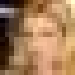

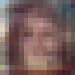

epoch =  331
Epoch [330/500], Step [438/438], d_loss: -7.0268, g_loss: -0.5579, D(x): 10.10, D(G(z)): 1.22


Epoch: 333: 100%|██████████| 438/438 [00:28<00:00, 15.60it/s, D_total_loss=-6.95, G_loss=-.884, fake_score=0.524, real_score=9.98]


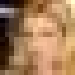

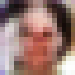

epoch =  333
Epoch [332/500], Step [438/438], d_loss: -6.9523, g_loss: -0.8843, D(x): 9.98, D(G(z)): 0.52


Epoch: 335: 100%|██████████| 438/438 [00:27<00:00, 15.92it/s, D_total_loss=59.2, G_loss=-.703, fake_score=1.76, real_score=9.85]


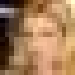

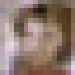

epoch =  335
Epoch [334/500], Step [438/438], d_loss: 59.1515, g_loss: -0.7034, D(x): 9.85, D(G(z)): 1.76


Epoch: 337: 100%|██████████| 438/438 [00:27<00:00, 15.67it/s, D_total_loss=-8.26, G_loss=-.584, fake_score=0.557, real_score=10.4]


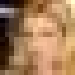

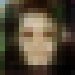

epoch =  337
Epoch [336/500], Step [438/438], d_loss: -8.2566, g_loss: -0.5844, D(x): 10.38, D(G(z)): 0.56


Epoch: 339: 100%|██████████| 438/438 [00:27<00:00, 16.10it/s, D_total_loss=-10.7, G_loss=-.439, fake_score=0.0817, real_score=11]


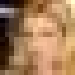

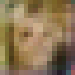

epoch =  339
Epoch [338/500], Step [438/438], d_loss: -10.6715, g_loss: -0.4388, D(x): 10.95, D(G(z)): 0.08


Epoch: 341: 100%|██████████| 438/438 [00:27<00:00, 15.68it/s, D_total_loss=-9.12, G_loss=-1.26, fake_score=0.408, real_score=10.1]


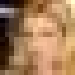

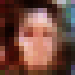

epoch =  341
Epoch [340/500], Step [438/438], d_loss: -9.1177, g_loss: -1.2603, D(x): 10.10, D(G(z)): 0.41


Epoch: 343: 100%|██████████| 438/438 [00:27<00:00, 16.05it/s, D_total_loss=-10.6, G_loss=-.599, fake_score=0.408, real_score=11.6]


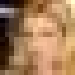

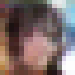

epoch =  343
Epoch [342/500], Step [438/438], d_loss: -10.5652, g_loss: -0.5987, D(x): 11.60, D(G(z)): 0.41


Epoch: 345: 100%|██████████| 438/438 [00:27<00:00, 15.86it/s, D_total_loss=-10.3, G_loss=-.799, fake_score=0.243, real_score=12.1]


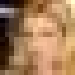

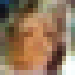

epoch =  345
Epoch [344/500], Step [438/438], d_loss: -10.3188, g_loss: -0.7992, D(x): 12.12, D(G(z)): 0.24


Epoch: 347: 100%|██████████| 438/438 [00:27<00:00, 15.91it/s, D_total_loss=-10.6, G_loss=-1.68, fake_score=0.754, real_score=11.9]


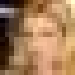

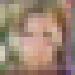

epoch =  347
Epoch [346/500], Step [438/438], d_loss: -10.6388, g_loss: -1.6797, D(x): 11.89, D(G(z)): 0.75


Epoch: 349: 100%|██████████| 438/438 [00:27<00:00, 15.95it/s, D_total_loss=-12.1, G_loss=-.827, fake_score=0.597, real_score=13.2]


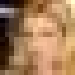

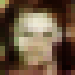

epoch =  349
Epoch [348/500], Step [438/438], d_loss: -12.0571, g_loss: -0.8269, D(x): 13.23, D(G(z)): 0.60


Epoch: 351: 100%|██████████| 438/438 [00:27<00:00, 15.87it/s, D_total_loss=-10.9, G_loss=-.995, fake_score=0.765, real_score=12]


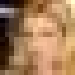

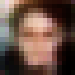

epoch =  351
Epoch [350/500], Step [438/438], d_loss: -10.8778, g_loss: -0.9953, D(x): 12.02, D(G(z)): 0.77


Epoch: 353: 100%|██████████| 438/438 [00:27<00:00, 15.78it/s, D_total_loss=-7.02, G_loss=-1.36, fake_score=0.665, real_score=12]


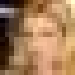

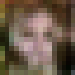

epoch =  353
Epoch [352/500], Step [438/438], d_loss: -7.0230, g_loss: -1.3551, D(x): 12.04, D(G(z)): 0.67


Epoch: 355: 100%|██████████| 438/438 [00:27<00:00, 15.85it/s, D_total_loss=-9.96, G_loss=0.19, fake_score=1.33, real_score=11.7]


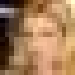

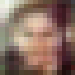

epoch =  355
Epoch [354/500], Step [438/438], d_loss: -9.9557, g_loss: 0.1899, D(x): 11.69, D(G(z)): 1.33


Epoch: 357: 100%|██████████| 438/438 [00:28<00:00, 15.60it/s, D_total_loss=-9.05, G_loss=-1.45, fake_score=0.634, real_score=11]


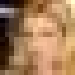

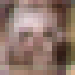

epoch =  357
Epoch [356/500], Step [438/438], d_loss: -9.0519, g_loss: -1.4450, D(x): 10.99, D(G(z)): 0.63


Epoch: 359: 100%|██████████| 438/438 [00:27<00:00, 15.83it/s, D_total_loss=-9.78, G_loss=-.631, fake_score=0.517, real_score=11.9]


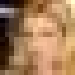

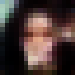

epoch =  359
Epoch [358/500], Step [438/438], d_loss: -9.7756, g_loss: -0.6307, D(x): 11.90, D(G(z)): 0.52


Epoch: 361: 100%|██████████| 438/438 [00:27<00:00, 15.75it/s, D_total_loss=-12.8, G_loss=-.666, fake_score=-.879, real_score=12.1]


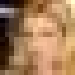

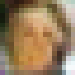

epoch =  361
Epoch [360/500], Step [438/438], d_loss: -12.8490, g_loss: -0.6655, D(x): 12.06, D(G(z)): -0.88


Epoch: 363: 100%|██████████| 438/438 [00:27<00:00, 15.73it/s, D_total_loss=-11.1, G_loss=-.564, fake_score=0.463, real_score=11.8]


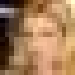

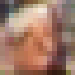

epoch =  363
Epoch [362/500], Step [438/438], d_loss: -11.1139, g_loss: -0.5637, D(x): 11.76, D(G(z)): 0.46


Epoch: 365: 100%|██████████| 438/438 [00:27<00:00, 15.68it/s, D_total_loss=-11.2, G_loss=-.847, fake_score=0.94, real_score=12.3]


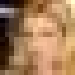

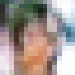

epoch =  365
Epoch [364/500], Step [438/438], d_loss: -11.1592, g_loss: -0.8471, D(x): 12.31, D(G(z)): 0.94


Epoch: 367: 100%|██████████| 438/438 [00:27<00:00, 15.88it/s, D_total_loss=1.7, G_loss=0.0204, fake_score=0.801, real_score=12.2]


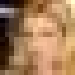

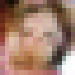

epoch =  367
Epoch [366/500], Step [438/438], d_loss: 1.6962, g_loss: 0.0204, D(x): 12.16, D(G(z)): 0.80


Epoch: 369: 100%|██████████| 438/438 [00:27<00:00, 15.65it/s, D_total_loss=-11.1, G_loss=0.144, fake_score=0.202, real_score=11.6]


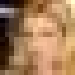

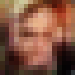

epoch =  369
Epoch [368/500], Step [438/438], d_loss: -11.0543, g_loss: 0.1438, D(x): 11.64, D(G(z)): 0.20


Epoch: 371: 100%|██████████| 438/438 [00:28<00:00, 15.57it/s, D_total_loss=-12, G_loss=-.0751, fake_score=-.523, real_score=11.7]


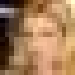

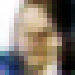

epoch =  371
Epoch [370/500], Step [438/438], d_loss: -12.0127, g_loss: -0.0751, D(x): 11.67, D(G(z)): -0.52


Epoch: 373: 100%|██████████| 438/438 [00:27<00:00, 16.10it/s, D_total_loss=-12.9, G_loss=-.756, fake_score=-.413, real_score=13]


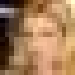

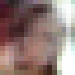

epoch =  373
Epoch [372/500], Step [438/438], d_loss: -12.8501, g_loss: -0.7559, D(x): 12.96, D(G(z)): -0.41


Epoch: 375: 100%|██████████| 438/438 [00:28<00:00, 15.42it/s, D_total_loss=-11, G_loss=-.5, fake_score=0.271, real_score=12.1]


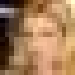

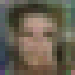

epoch =  375
Epoch [374/500], Step [438/438], d_loss: -10.9922, g_loss: -0.5004, D(x): 12.11, D(G(z)): 0.27


Epoch: 377: 100%|██████████| 438/438 [00:27<00:00, 15.84it/s, D_total_loss=-9.05, G_loss=0.316, fake_score=0.928, real_score=12.1]


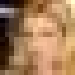

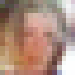

epoch =  377
Epoch [376/500], Step [438/438], d_loss: -9.0544, g_loss: 0.3164, D(x): 12.12, D(G(z)): 0.93


Epoch: 379: 100%|██████████| 438/438 [00:28<00:00, 15.49it/s, D_total_loss=-9.92, G_loss=-1.07, fake_score=1.21, real_score=11.3]


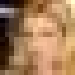

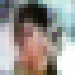

epoch =  379
Epoch [378/500], Step [438/438], d_loss: -9.9199, g_loss: -1.0677, D(x): 11.31, D(G(z)): 1.21


Epoch: 381: 100%|██████████| 438/438 [00:27<00:00, 15.87it/s, D_total_loss=-11, G_loss=-1.34, fake_score=0.887, real_score=12.6]


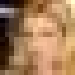

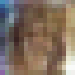

epoch =  381
Epoch [380/500], Step [438/438], d_loss: -10.9596, g_loss: -1.3445, D(x): 12.60, D(G(z)): 0.89


Epoch: 383: 100%|██████████| 438/438 [00:27<00:00, 15.65it/s, D_total_loss=-10.4, G_loss=-1.15, fake_score=1.62, real_score=12.3]


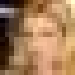

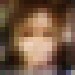

epoch =  383
Epoch [382/500], Step [438/438], d_loss: -10.4482, g_loss: -1.1475, D(x): 12.30, D(G(z)): 1.62


Epoch: 385: 100%|██████████| 438/438 [00:28<00:00, 15.23it/s, D_total_loss=-12, G_loss=0.132, fake_score=-.671, real_score=11.5]


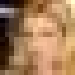

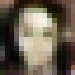

epoch =  385
Epoch [384/500], Step [438/438], d_loss: -11.9546, g_loss: 0.1318, D(x): 11.53, D(G(z)): -0.67


Epoch: 387: 100%|██████████| 438/438 [00:28<00:00, 15.31it/s, D_total_loss=-10.8, G_loss=-.995, fake_score=1.11, real_score=12.9]


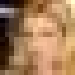

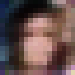

epoch =  387
Epoch [386/500], Step [438/438], d_loss: -10.7990, g_loss: -0.9945, D(x): 12.94, D(G(z)): 1.11


Epoch: 389: 100%|██████████| 438/438 [00:28<00:00, 15.20it/s, D_total_loss=-14.6, G_loss=-.00841, fake_score=-1.45, real_score=13.3]


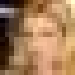

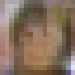

epoch =  389
Epoch [388/500], Step [438/438], d_loss: -14.5671, g_loss: -0.0084, D(x): 13.30, D(G(z)): -1.45


Epoch: 391: 100%|██████████| 438/438 [00:28<00:00, 15.62it/s, D_total_loss=-8.34, G_loss=-.159, fake_score=1.04, real_score=12.4]


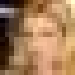

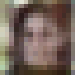

epoch =  391
Epoch [390/500], Step [438/438], d_loss: -8.3405, g_loss: -0.1595, D(x): 12.38, D(G(z)): 1.04


Epoch: 393: 100%|██████████| 438/438 [00:28<00:00, 15.60it/s, D_total_loss=-9.05, G_loss=-.29, fake_score=0.377, real_score=12.8]


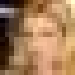

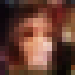

epoch =  393
Epoch [392/500], Step [438/438], d_loss: -9.0464, g_loss: -0.2896, D(x): 12.84, D(G(z)): 0.38


Epoch: 395: 100%|██████████| 438/438 [00:28<00:00, 15.29it/s, D_total_loss=-11.7, G_loss=-.631, fake_score=0.712, real_score=12.6]


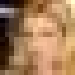

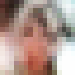

epoch =  395
Epoch [394/500], Step [438/438], d_loss: -11.6958, g_loss: -0.6308, D(x): 12.65, D(G(z)): 0.71


Epoch: 397: 100%|██████████| 438/438 [00:29<00:00, 15.06it/s, D_total_loss=-5.63, G_loss=-.883, fake_score=0.103, real_score=12.4]


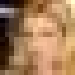

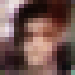

epoch =  397
Epoch [396/500], Step [438/438], d_loss: -5.6335, g_loss: -0.8833, D(x): 12.44, D(G(z)): 0.10


Epoch: 399: 100%|██████████| 438/438 [00:27<00:00, 15.65it/s, D_total_loss=-12.7, G_loss=-.149, fake_score=-.404, real_score=12.9]


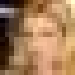

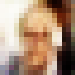

epoch =  399
Epoch [398/500], Step [438/438], d_loss: -12.6893, g_loss: -0.1495, D(x): 12.90, D(G(z)): -0.40


Epoch: 401: 100%|██████████| 438/438 [00:28<00:00, 15.64it/s, D_total_loss=-7.93, G_loss=-.166, fake_score=0.00495, real_score=12.7]


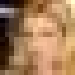

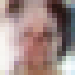

epoch =  401
Epoch [400/500], Step [438/438], d_loss: -7.9280, g_loss: -0.1656, D(x): 12.73, D(G(z)): 0.00


Epoch: 403: 100%|██████████| 438/438 [00:28<00:00, 15.18it/s, D_total_loss=-11, G_loss=-.37, fake_score=-.352, real_score=12.6]


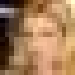

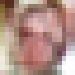

epoch =  403
Epoch [402/500], Step [438/438], d_loss: -10.9953, g_loss: -0.3701, D(x): 12.57, D(G(z)): -0.35


Epoch: 405: 100%|██████████| 438/438 [00:28<00:00, 15.35it/s, D_total_loss=-12.9, G_loss=0.235, fake_score=-.635, real_score=12.8]


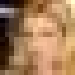

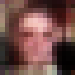

epoch =  405
Epoch [404/500], Step [438/438], d_loss: -12.9095, g_loss: 0.2348, D(x): 12.75, D(G(z)): -0.64


Epoch: 407: 100%|██████████| 438/438 [00:29<00:00, 15.10it/s, D_total_loss=-12.2, G_loss=0.238, fake_score=0.818, real_score=13.4]


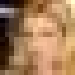

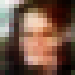

epoch =  407
Epoch [406/500], Step [438/438], d_loss: -12.1868, g_loss: 0.2377, D(x): 13.39, D(G(z)): 0.82


Epoch: 409: 100%|██████████| 438/438 [00:28<00:00, 15.37it/s, D_total_loss=-9.26, G_loss=0.301, fake_score=0.665, real_score=12.8]


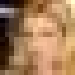

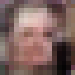

epoch =  409
Epoch [408/500], Step [438/438], d_loss: -9.2627, g_loss: 0.3008, D(x): 12.79, D(G(z)): 0.67


Epoch: 411: 100%|██████████| 438/438 [00:28<00:00, 15.33it/s, D_total_loss=-11.7, G_loss=-.245, fake_score=-.158, real_score=13.1]


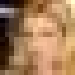

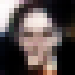

epoch =  411
Epoch [410/500], Step [438/438], d_loss: -11.7215, g_loss: -0.2445, D(x): 13.14, D(G(z)): -0.16


Epoch: 413: 100%|██████████| 438/438 [00:29<00:00, 14.97it/s, D_total_loss=-11.3, G_loss=-.957, fake_score=0.519, real_score=12.3]


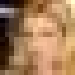

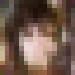

epoch =  413
Epoch [412/500], Step [438/438], d_loss: -11.2551, g_loss: -0.9567, D(x): 12.34, D(G(z)): 0.52


Epoch: 415: 100%|██████████| 438/438 [00:28<00:00, 15.12it/s, D_total_loss=-7.26, G_loss=-.42, fake_score=0.373, real_score=14.3]


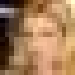

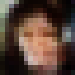

epoch =  415
Epoch [414/500], Step [438/438], d_loss: -7.2647, g_loss: -0.4199, D(x): 14.28, D(G(z)): 0.37


Epoch: 417: 100%|██████████| 438/438 [00:28<00:00, 15.24it/s, D_total_loss=-11.5, G_loss=-.274, fake_score=-.474, real_score=14.1]


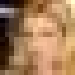

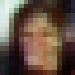

epoch =  417
Epoch [416/500], Step [438/438], d_loss: -11.4675, g_loss: -0.2743, D(x): 14.11, D(G(z)): -0.47


Epoch: 419: 100%|██████████| 438/438 [00:29<00:00, 14.89it/s, D_total_loss=-13, G_loss=0.85, fake_score=-.664, real_score=12.5]


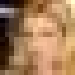

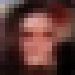

epoch =  419
Epoch [418/500], Step [438/438], d_loss: -13.0257, g_loss: 0.8505, D(x): 12.54, D(G(z)): -0.66


Epoch: 421: 100%|██████████| 438/438 [00:29<00:00, 14.80it/s, D_total_loss=-12.4, G_loss=0.234, fake_score=-.356, real_score=13.3]


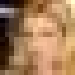

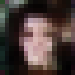

epoch =  421
Epoch [420/500], Step [438/438], d_loss: -12.3532, g_loss: 0.2338, D(x): 13.29, D(G(z)): -0.36


Epoch: 423: 100%|██████████| 438/438 [00:28<00:00, 15.26it/s, D_total_loss=0.274, G_loss=0.0548, fake_score=-1.3, real_score=12.1]


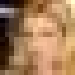

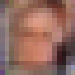

epoch =  423
Epoch [422/500], Step [438/438], d_loss: 0.2740, g_loss: 0.0548, D(x): 12.08, D(G(z)): -1.30


Epoch: 425: 100%|██████████| 438/438 [00:29<00:00, 14.96it/s, D_total_loss=-4.59, G_loss=-.594, fake_score=1.39, real_score=13.3]


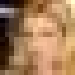

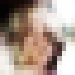

epoch =  425
Epoch [424/500], Step [438/438], d_loss: -4.5889, g_loss: -0.5939, D(x): 13.29, D(G(z)): 1.39


Epoch: 427: 100%|██████████| 438/438 [00:28<00:00, 15.18it/s, D_total_loss=-11.6, G_loss=-.212, fake_score=-.755, real_score=12.8]


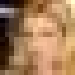

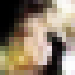

epoch =  427
Epoch [426/500], Step [438/438], d_loss: -11.5898, g_loss: -0.2119, D(x): 12.80, D(G(z)): -0.76


Epoch: 429: 100%|██████████| 438/438 [00:29<00:00, 14.89it/s, D_total_loss=-9.67, G_loss=0.495, fake_score=0.602, real_score=13.4]


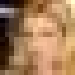

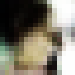

epoch =  429
Epoch [428/500], Step [438/438], d_loss: -9.6733, g_loss: 0.4947, D(x): 13.36, D(G(z)): 0.60


Epoch: 431: 100%|██████████| 438/438 [00:29<00:00, 14.89it/s, D_total_loss=-14.7, G_loss=-.199, fake_score=-.543, real_score=15]


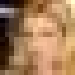

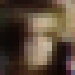

epoch =  431
Epoch [430/500], Step [438/438], d_loss: -14.6540, g_loss: -0.1988, D(x): 15.00, D(G(z)): -0.54


Epoch: 433: 100%|██████████| 438/438 [00:28<00:00, 15.23it/s, D_total_loss=-13.6, G_loss=-.231, fake_score=0.826, real_score=14.8]


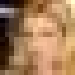

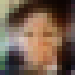

epoch =  433
Epoch [432/500], Step [438/438], d_loss: -13.6030, g_loss: -0.2311, D(x): 14.78, D(G(z)): 0.83


Epoch: 435: 100%|██████████| 438/438 [00:30<00:00, 14.59it/s, D_total_loss=-9.99, G_loss=0.371, fake_score=0.296, real_score=13.9]


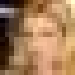

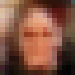

epoch =  435
Epoch [434/500], Step [438/438], d_loss: -9.9881, g_loss: 0.3711, D(x): 13.87, D(G(z)): 0.30


Epoch: 437: 100%|██████████| 438/438 [00:29<00:00, 15.02it/s, D_total_loss=20, G_loss=-.482, fake_score=0.775, real_score=13.9]


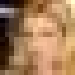

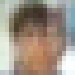

epoch =  437
Epoch [436/500], Step [438/438], d_loss: 19.9806, g_loss: -0.4825, D(x): 13.89, D(G(z)): 0.78


Epoch: 439: 100%|██████████| 438/438 [00:30<00:00, 14.59it/s, D_total_loss=-15.4, G_loss=0.689, fake_score=-.332, real_score=15.6]


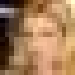

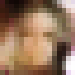

epoch =  439
Epoch [438/500], Step [438/438], d_loss: -15.3844, g_loss: 0.6891, D(x): 15.58, D(G(z)): -0.33


Epoch: 441: 100%|██████████| 438/438 [00:29<00:00, 14.84it/s, D_total_loss=-11.4, G_loss=-.292, fake_score=0.0507, real_score=13.2]


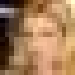

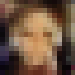

epoch =  441
Epoch [440/500], Step [438/438], d_loss: -11.3510, g_loss: -0.2916, D(x): 13.22, D(G(z)): 0.05


Epoch: 443: 100%|██████████| 438/438 [00:29<00:00, 14.83it/s, D_total_loss=-15.3, G_loss=-.00678, fake_score=-1.94, real_score=13.6]


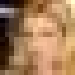

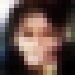

epoch =  443
Epoch [442/500], Step [438/438], d_loss: -15.3454, g_loss: -0.0068, D(x): 13.64, D(G(z)): -1.94


Epoch: 445: 100%|██████████| 438/438 [00:29<00:00, 14.67it/s, D_total_loss=-13.2, G_loss=-.495, fake_score=-.858, real_score=13.8]


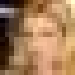

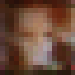

epoch =  445
Epoch [444/500], Step [438/438], d_loss: -13.2060, g_loss: -0.4952, D(x): 13.77, D(G(z)): -0.86


Epoch: 447: 100%|██████████| 438/438 [00:30<00:00, 14.44it/s, D_total_loss=-11.9, G_loss=0.421, fake_score=0.0606, real_score=13.8]


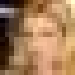

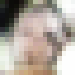

epoch =  447
Epoch [446/500], Step [438/438], d_loss: -11.8586, g_loss: 0.4211, D(x): 13.78, D(G(z)): 0.06


Epoch: 449: 100%|██████████| 438/438 [00:29<00:00, 15.06it/s, D_total_loss=-13.7, G_loss=0.299, fake_score=0.936, real_score=14.9]


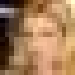

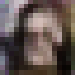

epoch =  449
Epoch [448/500], Step [438/438], d_loss: -13.7454, g_loss: 0.2994, D(x): 14.86, D(G(z)): 0.94


Epoch: 451: 100%|██████████| 438/438 [00:30<00:00, 14.53it/s, D_total_loss=-12.7, G_loss=0.609, fake_score=-.234, real_score=12.8]


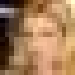

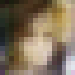

epoch =  451
Epoch [450/500], Step [438/438], d_loss: -12.7235, g_loss: 0.6090, D(x): 12.79, D(G(z)): -0.23


Epoch: 453: 100%|██████████| 438/438 [00:29<00:00, 15.09it/s, D_total_loss=-11.8, G_loss=1.65, fake_score=0.225, real_score=12.9]


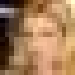

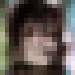

epoch =  453
Epoch [452/500], Step [438/438], d_loss: -11.8300, g_loss: 1.6464, D(x): 12.93, D(G(z)): 0.23


Epoch: 455: 100%|██████████| 438/438 [00:29<00:00, 14.83it/s, D_total_loss=-13.7, G_loss=-.117, fake_score=-.228, real_score=14.5]


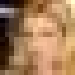

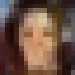

epoch =  455
Epoch [454/500], Step [438/438], d_loss: -13.6835, g_loss: -0.1169, D(x): 14.49, D(G(z)): -0.23


Epoch: 457: 100%|██████████| 438/438 [00:29<00:00, 14.85it/s, D_total_loss=-14.5, G_loss=0.682, fake_score=-.208, real_score=14.7]


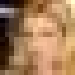

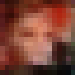

epoch =  457
Epoch [456/500], Step [438/438], d_loss: -14.5472, g_loss: 0.6819, D(x): 14.69, D(G(z)): -0.21


Epoch: 459: 100%|██████████| 438/438 [00:29<00:00, 14.88it/s, D_total_loss=-14.1, G_loss=0.896, fake_score=-.558, real_score=13.8]


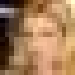

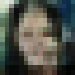

epoch =  459
Epoch [458/500], Step [438/438], d_loss: -14.0760, g_loss: 0.8964, D(x): 13.78, D(G(z)): -0.56


Epoch: 461: 100%|██████████| 438/438 [00:29<00:00, 14.92it/s, D_total_loss=-14.2, G_loss=0.341, fake_score=0.652, real_score=15.4]


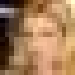

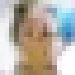

epoch =  461
Epoch [460/500], Step [438/438], d_loss: -14.1826, g_loss: 0.3409, D(x): 15.41, D(G(z)): 0.65


Epoch: 463: 100%|██████████| 438/438 [00:30<00:00, 14.52it/s, D_total_loss=20.8, G_loss=0.199, fake_score=-.839, real_score=14.3]


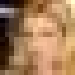

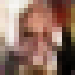

epoch =  463
Epoch [462/500], Step [438/438], d_loss: 20.7888, g_loss: 0.1988, D(x): 14.25, D(G(z)): -0.84


Epoch: 465: 100%|██████████| 438/438 [00:30<00:00, 14.53it/s, D_total_loss=-12.8, G_loss=1, fake_score=-.301, real_score=12.7]


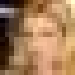

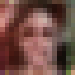

epoch =  465
Epoch [464/500], Step [438/438], d_loss: -12.8384, g_loss: 1.0017, D(x): 12.75, D(G(z)): -0.30


Epoch: 467: 100%|██████████| 438/438 [00:30<00:00, 14.38it/s, D_total_loss=-16.5, G_loss=-.0837, fake_score=-2.26, real_score=14.5]


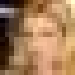

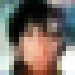

epoch =  467
Epoch [466/500], Step [438/438], d_loss: -16.5426, g_loss: -0.0837, D(x): 14.54, D(G(z)): -2.26


Epoch: 469: 100%|██████████| 438/438 [00:29<00:00, 14.88it/s, D_total_loss=-14.7, G_loss=1.13, fake_score=-.897, real_score=14]


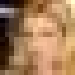

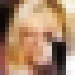

epoch =  469
Epoch [468/500], Step [438/438], d_loss: -14.7150, g_loss: 1.1252, D(x): 14.05, D(G(z)): -0.90


Epoch: 471: 100%|██████████| 438/438 [00:29<00:00, 14.88it/s, D_total_loss=-15.5, G_loss=0.546, fake_score=-.482, real_score=15.2]


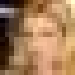

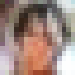

epoch =  471
Epoch [470/500], Step [438/438], d_loss: -15.4506, g_loss: 0.5455, D(x): 15.22, D(G(z)): -0.48


Epoch: 473: 100%|██████████| 438/438 [00:29<00:00, 14.96it/s, D_total_loss=-15.9, G_loss=1.4, fake_score=0.0664, real_score=16.3]


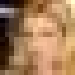

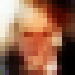

epoch =  473
Epoch [472/500], Step [438/438], d_loss: -15.8655, g_loss: 1.3975, D(x): 16.27, D(G(z)): 0.07


Epoch: 475: 100%|██████████| 438/438 [00:30<00:00, 14.37it/s, D_total_loss=-13.9, G_loss=1.38, fake_score=-.289, real_score=14]


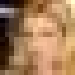

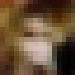

epoch =  475
Epoch [474/500], Step [438/438], d_loss: -13.8946, g_loss: 1.3810, D(x): 14.00, D(G(z)): -0.29


Epoch: 477: 100%|██████████| 438/438 [00:30<00:00, 14.57it/s, D_total_loss=-9.28, G_loss=0.732, fake_score=-1.16, real_score=13.6]


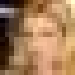

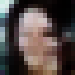

epoch =  477
Epoch [476/500], Step [438/438], d_loss: -9.2803, g_loss: 0.7318, D(x): 13.59, D(G(z)): -1.16


Epoch: 479: 100%|██████████| 438/438 [00:29<00:00, 14.99it/s, D_total_loss=-15.7, G_loss=1.07, fake_score=-1.15, real_score=14.8]


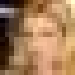

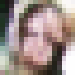

epoch =  479
Epoch [478/500], Step [438/438], d_loss: -15.7444, g_loss: 1.0673, D(x): 14.84, D(G(z)): -1.15


Epoch: 481: 100%|██████████| 438/438 [00:30<00:00, 14.48it/s, D_total_loss=2.47, G_loss=1.14, fake_score=-1.78, real_score=15]


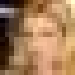

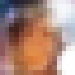

epoch =  481
Epoch [480/500], Step [438/438], d_loss: 2.4717, g_loss: 1.1393, D(x): 15.02, D(G(z)): -1.78


Epoch: 483: 100%|██████████| 438/438 [00:29<00:00, 14.87it/s, D_total_loss=-15.9, G_loss=2.38, fake_score=-2.98, real_score=13.5]


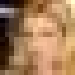

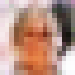

epoch =  483
Epoch [482/500], Step [438/438], d_loss: -15.9047, g_loss: 2.3751, D(x): 13.51, D(G(z)): -2.98


Epoch: 485: 100%|██████████| 438/438 [00:30<00:00, 14.53it/s, D_total_loss=-13.7, G_loss=1.22, fake_score=0.516, real_score=14.4]


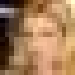

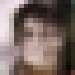

epoch =  485
Epoch [484/500], Step [438/438], d_loss: -13.6741, g_loss: 1.2227, D(x): 14.45, D(G(z)): 0.52


Epoch: 487: 100%|██████████| 438/438 [00:29<00:00, 14.72it/s, D_total_loss=-15.4, G_loss=1.04, fake_score=-1.41, real_score=16.3]


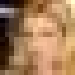

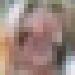

epoch =  487
Epoch [486/500], Step [438/438], d_loss: -15.4269, g_loss: 1.0440, D(x): 16.25, D(G(z)): -1.41


Epoch: 489: 100%|██████████| 438/438 [00:29<00:00, 14.60it/s, D_total_loss=-17.2, G_loss=2.37, fake_score=-2.2, real_score=16.6]


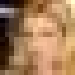

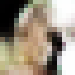

epoch =  489
Epoch [488/500], Step [438/438], d_loss: -17.2392, g_loss: 2.3663, D(x): 16.61, D(G(z)): -2.20


Epoch: 491: 100%|██████████| 438/438 [00:30<00:00, 14.50it/s, D_total_loss=-13.2, G_loss=1.58, fake_score=-.24, real_score=13.8]


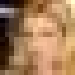

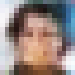

epoch =  491
Epoch [490/500], Step [438/438], d_loss: -13.2182, g_loss: 1.5794, D(x): 13.82, D(G(z)): -0.24


Epoch: 493: 100%|██████████| 438/438 [00:29<00:00, 14.61it/s, D_total_loss=-12.5, G_loss=0.556, fake_score=-1.34, real_score=13.3]


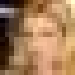

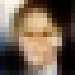

epoch =  493
Epoch [492/500], Step [438/438], d_loss: -12.5345, g_loss: 0.5565, D(x): 13.29, D(G(z)): -1.34


Epoch: 495: 100%|██████████| 438/438 [00:29<00:00, 14.73it/s, D_total_loss=-12.3, G_loss=1.83, fake_score=-.542, real_score=12.5]


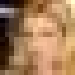

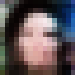

epoch =  495
Epoch [494/500], Step [438/438], d_loss: -12.3201, g_loss: 1.8291, D(x): 12.51, D(G(z)): -0.54


Epoch: 497: 100%|██████████| 438/438 [00:30<00:00, 14.52it/s, D_total_loss=-17.4, G_loss=1.35, fake_score=-2.43, real_score=15.7]


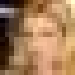

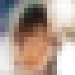

epoch =  497
Epoch [496/500], Step [438/438], d_loss: -17.4154, g_loss: 1.3502, D(x): 15.68, D(G(z)): -2.43


Epoch: 499: 100%|██████████| 438/438 [00:29<00:00, 14.86it/s, D_total_loss=-10.9, G_loss=1.92, fake_score=-.884, real_score=14.3]


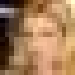

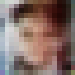

epoch =  499
Epoch [498/500], Step [438/438], d_loss: -10.8647, g_loss: 1.9157, D(x): 14.33, D(G(z)): -0.88


Epoch: 500: 100%|██████████| 438/438 [00:30<00:00, 14.38it/s, D_total_loss=-15, G_loss=1.29, fake_score=-1, real_score=15.2]


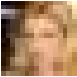

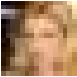

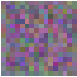

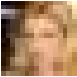

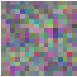

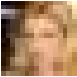

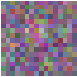

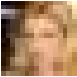

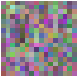

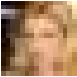

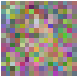

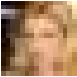

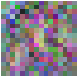

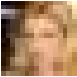

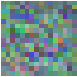

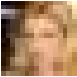

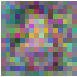

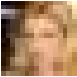

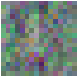

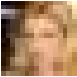

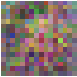

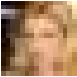

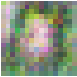

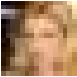

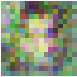

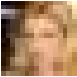

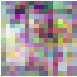

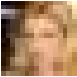

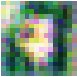

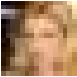

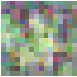

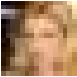

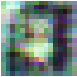

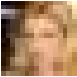

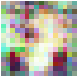

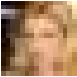

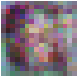

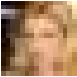

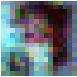

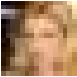

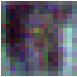

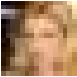

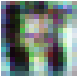

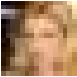

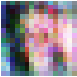

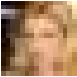

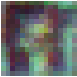

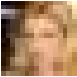

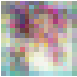

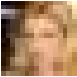

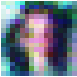

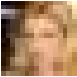

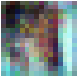

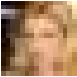

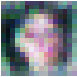

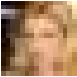

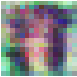

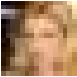

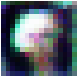

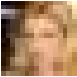

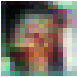

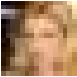

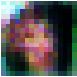

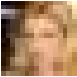

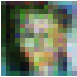

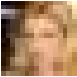

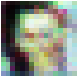

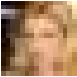

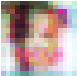

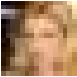

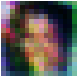

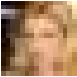

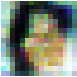

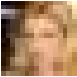

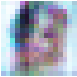

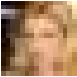

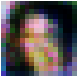

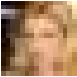

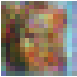

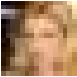

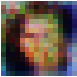

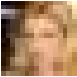

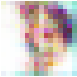

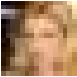

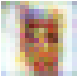

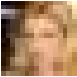

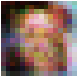

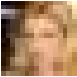

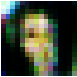

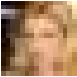

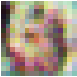

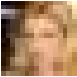

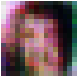

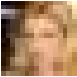

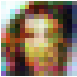

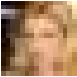

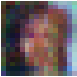

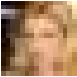

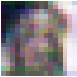

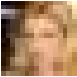

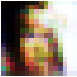

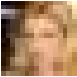

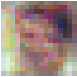

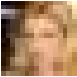

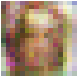

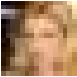

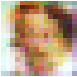

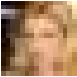

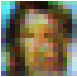

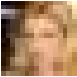

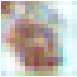

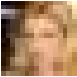

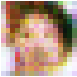

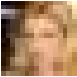

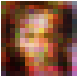

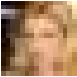

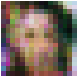

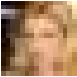

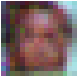

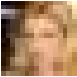

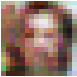

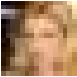

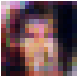

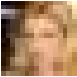

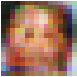

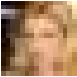

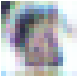

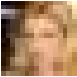

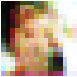

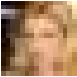

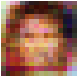

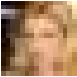

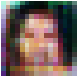

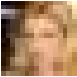

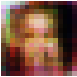

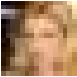

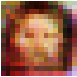

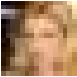

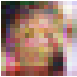

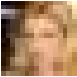

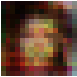

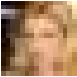

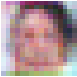

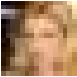

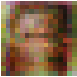

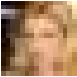

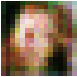

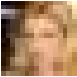

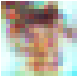

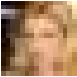

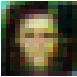

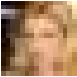

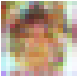

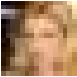

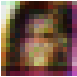

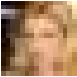

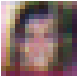

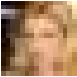

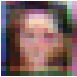

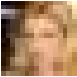

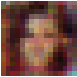

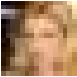

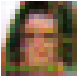

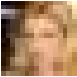

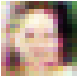

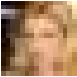

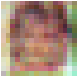

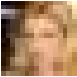

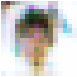

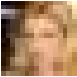

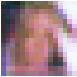

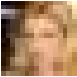

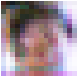

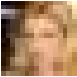

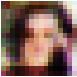

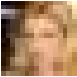

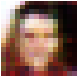

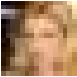

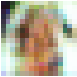

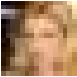

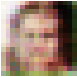

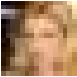

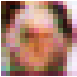

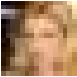

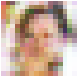

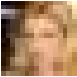

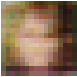

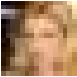

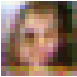

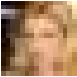

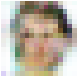

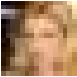

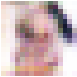

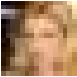

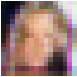

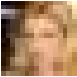

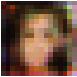

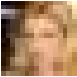

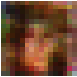

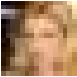

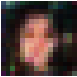

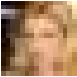

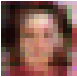

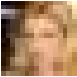

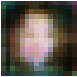

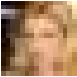

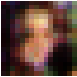

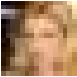

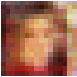

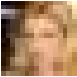

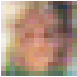

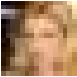

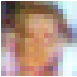

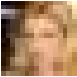

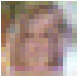

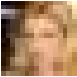

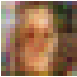

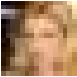

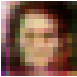

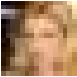

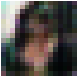

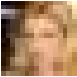

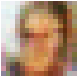

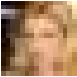

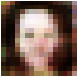

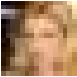

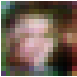

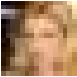

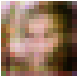

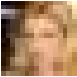

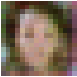

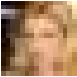

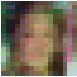

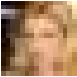

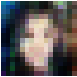

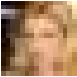

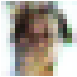

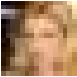

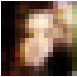

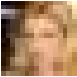

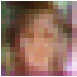

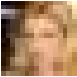

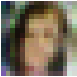

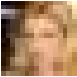

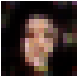

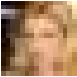

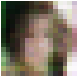

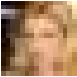

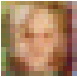

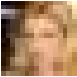

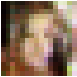

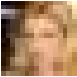

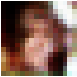

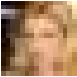

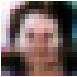

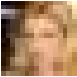

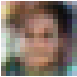

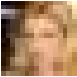

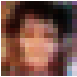

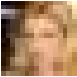

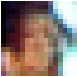

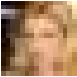

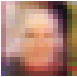

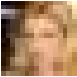

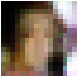

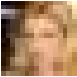

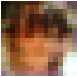

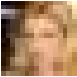

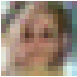

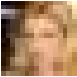

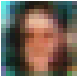

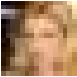

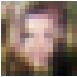

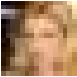

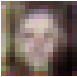

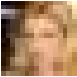

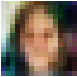

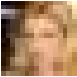

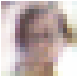

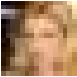

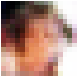

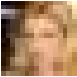

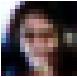

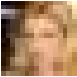

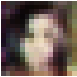

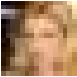

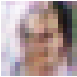

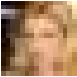

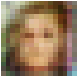

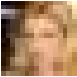

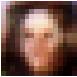

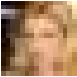

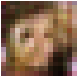

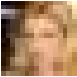

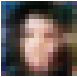

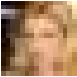

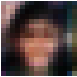

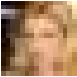

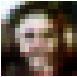

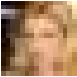

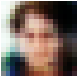

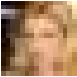

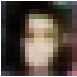

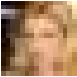

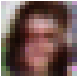

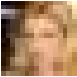

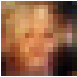

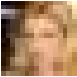

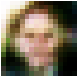

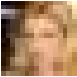

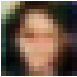

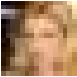

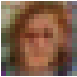

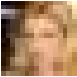

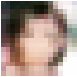

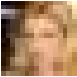

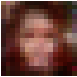

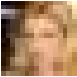

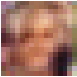

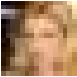

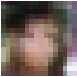

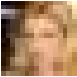

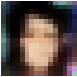

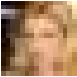

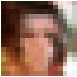

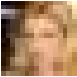

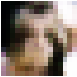

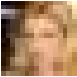

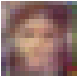

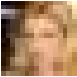

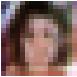

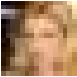

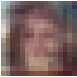

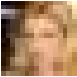

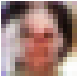

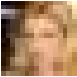

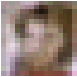

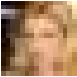

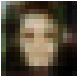

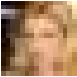

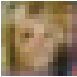

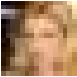

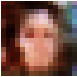

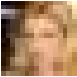

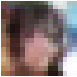

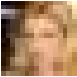

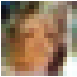

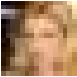

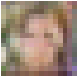

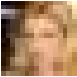

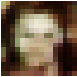

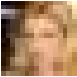

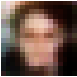

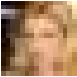

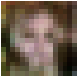

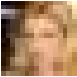

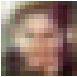

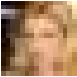

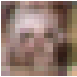

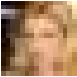

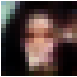

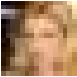

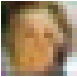

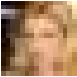

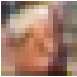

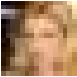

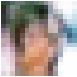

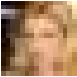

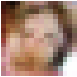

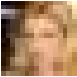

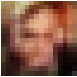

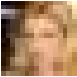

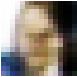

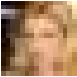

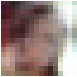

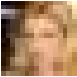

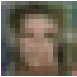

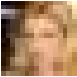

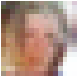

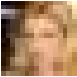

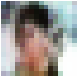

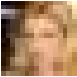

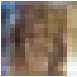

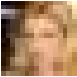

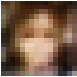

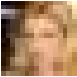

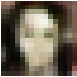

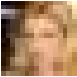

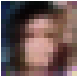

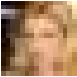

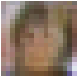

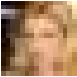

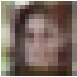

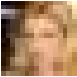

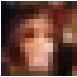

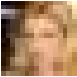

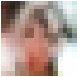

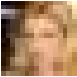

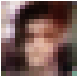

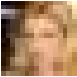

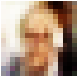

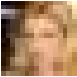

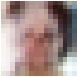

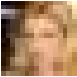

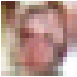

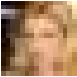

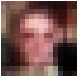

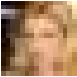

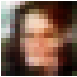

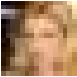

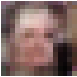

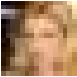

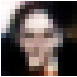

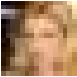

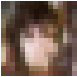

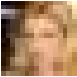

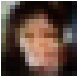

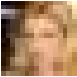

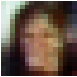

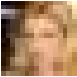

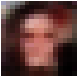

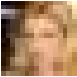

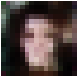

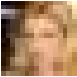

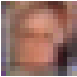

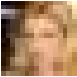

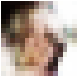

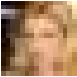

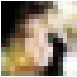

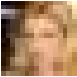

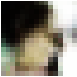

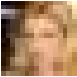

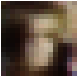

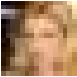

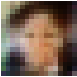

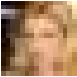

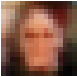

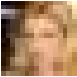

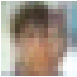

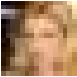

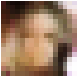

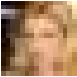

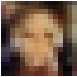

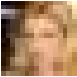

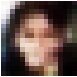

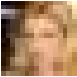

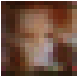

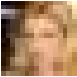

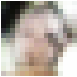

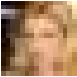

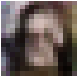

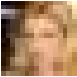

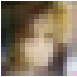

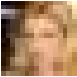

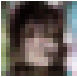

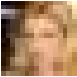

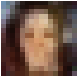

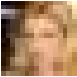

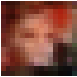

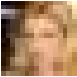

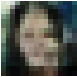

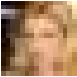

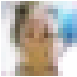

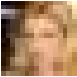

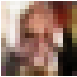

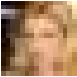

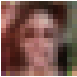

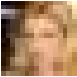

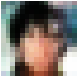

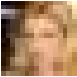

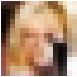

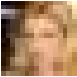

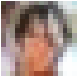

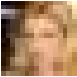

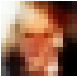

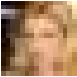

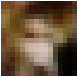

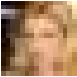

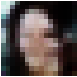

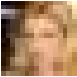

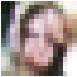

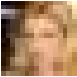

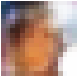

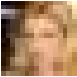

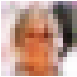

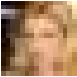

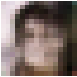

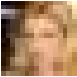

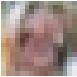

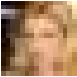

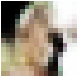

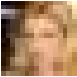

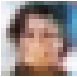

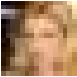

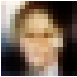

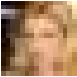

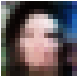

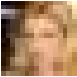

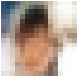

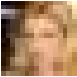

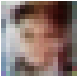

In [14]:
for i in range(iteration):

    p = tqdm(range(total_data_len // batch_size + 1)) # This is a progress bar run on each epoch
    
    datasets_batched = DataLoader(dataset, batch_size = batch_size)
    
    loader = iter(datasets_batched)

    d_step = 0

    for j in p:
        

        batchNum = str(i+1)
        
        #Training the D
        #real data
        real = next(loader).to(device)

        #current_batch size (the last batch is different than others)
        current_batch_size, c, h, w = real.shape
        #labels
        label_real = 0.1 * t.randint(7,10,(current_batch_size,1)).type(t.half)
        label_fake = 0.1 * t.randint(0,3,(current_batch_size,1)).type(t.half)

        real_score = discriminator(real)
        d_real_loss = -t.mean(real_score)
        
        input_noise = t.normal(0, 1, size = (current_batch_size, 1, 1, laten_space)).to(device)
        fake = generator(input_noise, current_batch_size)
        fake_score = discriminator(fake)

        d_fake_loss = t.mean(fake_score)

        gradient_penalty = compute_gradient_penalty(discriminator, real, fake, current_batch_size)
        
        total_loss = d_fake_loss + d_real_loss + gradient_penalty

        generator.zero_grad()
        discriminator.zero_grad()
        total_loss.backward()
        D_optimizer.step()

        d_step += 1

        if d_step == updatD_step:

          discriminatorReal.load_state_dict(discriminator.state_dict().copy())




        if j % critic == 0:
          input_noise = t.normal(0, 1, size = (current_batch_size, 1, 1, laten_space)).to(device)
          fake = generator(input_noise, current_batch_size)
          fake_score = discriminator(fake)
          g_fake_loss = -t.mean(fake_score)
          discriminator.zero_grad()
          generator.zero_grad()
          g_fake_loss.backward()
          G_optimizer.step()
          discriminator.load_state_dict(discriminatorReal.state_dict().copy())
          D_optimizer = t.optim.Adam(discriminator.parameters(), lr = 0.00001)
          d_step = 0
          

        
        mse = "Epoch: " + batchNum
        
        p.set_description(mse)
            
        p.set_postfix(G_loss = g_fake_loss.item(), D_total_loss = total_loss.item(), real_score = real_score.mean().item(), fake_score = fake_score.mean().item())
        
    if i == 0:
        showOneImge(real[0], 99999, True)   
    
    if i % 2 == 0:
      
      showOneImge(real[0], 99999, False)
      showOneImge(fake[0], i, False)
      print("epoch = ", i + 1)  
      print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'.format(i, iteration, j+1, total_data_len // batch_size + 1, total_loss.item(), g_fake_loss.item(), real_score.mean().item(), fake_score.mean().item()))      
      

    if i % 50 == 0:
      t.save(generator.state_dict(), f'{log_folder}/checkpoint/{str(i + 1).zfill(6)}_g.model')
      t.save(discriminator.state_dict(), f'{log_folder}/checkpoint/{str(i + 1).zfill(6)}_d.model')


### Show Result

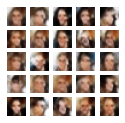

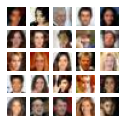

In [15]:


#Generated
generator.eval()

with t.no_grad():
  input_noise = t.normal(0, 1, size = (eval_size, 1, 1, laten_space)).to(device)
  generated = generator(input_noise, eval_size)
  showMoreImages(generated, eval_size)

#Real
datasets_batched = DataLoader(dataset, batch_size = eval_size)
loader = iter(datasets_batched)
real = next(loader)
showMoreImages(real, eval_size)

### remove log file when necessarry

In [16]:
# !rm -rf /content/log/checkpoint

# !mkdir /content/log/checkpoint

# !rm -rf /content/log/sample
# !mkdir /content/log/sample

# from google.colab import files
# files.download('/content/log') 